In [1]:
# Libraries
import tensorflow
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, ConcatDataset
from transformers import AutoTokenizer, BertTokenizer 

import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from ABSA_SentimentMultiEmiten.model.bert import bert_ABSA
from ABSA_SentimentMultiEmiten.data.dataset import dataset_ABSA

2023-06-03 13:59:29.688738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Menentukan device yang akan digunakan untuk melakukan komputasi
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

print("Tensorflow\t: ", tensorflow.__version__)
print("Torch\t\t: ", torch.__version__)
print("Device\t\t: ", DEVICE)
print("GPU\t\t: ", torch.cuda.get_device_name())
print("CUDA\t\t: ", torch.version.cuda)

Tensorflow	:  2.4.1
Torch		:  1.4.0
Device		:  cuda:2
GPU		:  Tesla T4
CUDA		:  10.1


In [3]:
# Inisialisasi hyperparameter
bs = 8
lr = 0.00002
epoch = 8

In [4]:
# Inisialisasi pre-trained model IndoBERT
pretrained_model_name = "indolem/indobert-base-uncased"
model_name = "indolem-indobert.pkl"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model_ABSA = bert_ABSA(pretrained_model_name)
model_ABSA.to(DEVICE)
optimizer_ABSA = torch.optim.Adam(model_ABSA.parameters(), lr=lr)

In [5]:
# Function untuk konversi waktu dari detik ke jam, menit, detik
def evl_time(t):
    min, sec= divmod(t, 60)
    hr, min = divmod(min, 60)
    return int(hr), int(min), int(sec)

# Function untuk menyimpan model
def save_model(model, name):
    torch.save(model.state_dict(), name)

# Function untuk load model
def load_model(model, path):
    model.load_state_dict(torch.load(path), strict=False)
    return model

In [6]:
# Mengubah dataset menjadi beberapa mini-batch
def create_mini_batch(samples):
    ids_tensors = [s[1] for s in samples]
    ids_tensors = pad_sequence(ids_tensors, batch_first=True)

    segments_tensors = [s[2] for s in samples]
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    label_ids = torch.stack([s[3] for s in samples])
    
    masks_tensors = torch.zeros(ids_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(ids_tensors != 0, 1)

    return ids_tensors, segments_tensors, masks_tensors, label_ids

In [7]:
# Function untuk pelatihan model
def train_model_ABSA(loader, epochs, model_name):
    history = {'loss' : []}
    all_data = len(loader)
    
    # Pengulangan epoch
    for epoch in range(epochs):
        finish_data = 0
        losses = []
        current_times = []
        
        # Pengulangan setiap mini-batch
        for data in loader:
            t0 = time.time()
            ids_tensors, segments_tensors, masks_tensors, label_ids = data
            ids_tensors = ids_tensors.to(DEVICE)
            segments_tensors = segments_tensors.to(DEVICE)
            label_ids = label_ids.to(DEVICE)
            masks_tensors = masks_tensors.to(DEVICE)

            loss = model_ABSA(ids_tensors=ids_tensors, lable_tensors=label_ids, masks_tensors=masks_tensors, segments_tensors=segments_tensors)
            losses.append(loss.item())
            loss.backward()
            optimizer_ABSA.step()
            optimizer_ABSA.zero_grad()

            finish_data += 1
            current_times.append(round(time.time()-t0,3))
            current = np.mean(current_times)
            hr, min, sec = evl_time(current*(all_data-finish_data) + current*all_data*(epochs-epoch-1))
            print('epoch:', epoch+1, "/" , epochs," batch:", finish_data, "/" , all_data, " loss:", np.mean(losses), " hr:", hr, " min:", min," sec:", sec)

        history['loss'].append(np.mean(losses))
        save_model(model_ABSA, model_name)
    
    return history

# Function untuk pengujian model
def test_model_ABSA(loader):
    pred = []
    truth = []
    
    with torch.no_grad():
        # Pengulangan setiap mini-batch
        for data in loader:
            ids_tensors, segments_tensors, masks_tensors, label_ids = data
            ids_tensors = ids_tensors.to(DEVICE)
            segments_tensors = segments_tensors.to(DEVICE)
            masks_tensors = masks_tensors.to(DEVICE)

            outputs = model_ABSA(ids_tensors, None, masks_tensors=masks_tensors, segments_tensors=segments_tensors)
            
            _, predictions = torch.max(outputs, dim=1)

            pred += list([int(i) for i in predictions])
            truth += list([int(i) for i in label_ids])

    return truth, pred

In [8]:
# Function untuk menampilkan confusion matrix
def draw_c_matrix(c_matrix, title="test"):
    aix = []
    
    for y in range(len(c_matrix)):
        aix.append(y)
    df_cm = pd.DataFrame(c_matrix, aix, aix)
    sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.ylabel("prediction")
    plt.xlabel("ground truth")
    plt.title(title)
    plt.show()

In [9]:
# Inisialisasi dataset
emiten_train_ds = dataset_ABSA(pd.read_csv("data_experiment/data_balance_experiment_training.csv"), tokenizer)
emiten_test_ds = dataset_ABSA(pd.read_csv("data_experiment/data_balance_experiment_testing.csv"), tokenizer)

train_ds = ConcatDataset([emiten_train_ds])
test_ds = ConcatDataset([emiten_test_ds])

# Mengubah dataset menjadi mini-batch
train_loader = DataLoader(train_ds, batch_size=bs, collate_fn=create_mini_batch, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=bs, collate_fn=create_mini_batch, shuffle = True)

In [10]:
# Proses training model
history = %time train_model_ABSA(train_loader, epoch, model_name)

epoch: 1 / 8  batch: 1 / 1224  loss: 1.1103699207305908  hr: 1  min: 11  sec: 8
epoch: 1 / 8  batch: 2 / 1224  loss: 1.0890239477157593  hr: 0  min: 52  sec: 47
epoch: 1 / 8  batch: 3 / 1224  loss: 1.1180886030197144  hr: 0  min: 40  sec: 50
epoch: 1 / 8  batch: 4 / 1224  loss: 1.096144825220108  hr: 0  min: 39  sec: 9
epoch: 1 / 8  batch: 5 / 1224  loss: 1.0802822589874268  hr: 0  min: 37  sec: 52
epoch: 1 / 8  batch: 6 / 1224  loss: 1.0625442465146382  hr: 0  min: 37  sec: 11
epoch: 1 / 8  batch: 7 / 1224  loss: 1.0291421498571123  hr: 0  min: 37  sec: 27
epoch: 1 / 8  batch: 8 / 1224  loss: 1.049548514187336  hr: 0  min: 36  sec: 59
epoch: 1 / 8  batch: 9 / 1224  loss: 1.0559190577930875  hr: 0  min: 35  sec: 56
epoch: 1 / 8  batch: 10 / 1224  loss: 1.0728929817676545  hr: 0  min: 35  sec: 38
epoch: 1 / 8  batch: 11 / 1224  loss: 1.0690437934615395  hr: 0  min: 35  sec: 22
epoch: 1 / 8  batch: 12 / 1224  loss: 1.058681736389796  hr: 0  min: 35  sec: 23
epoch: 1 / 8  batch: 13 / 1224

epoch: 1 / 8  batch: 102 / 1224  loss: 0.9558050953874401  hr: 0  min: 29  sec: 29
epoch: 1 / 8  batch: 103 / 1224  loss: 0.9570104259889103  hr: 0  min: 29  sec: 20
epoch: 1 / 8  batch: 104 / 1224  loss: 0.9579850979722463  hr: 0  min: 29  sec: 24
epoch: 1 / 8  batch: 105 / 1224  loss: 0.9561046220007396  hr: 0  min: 29  sec: 26
epoch: 1 / 8  batch: 106 / 1224  loss: 0.9544266344241377  hr: 0  min: 29  sec: 20
epoch: 1 / 8  batch: 107 / 1224  loss: 0.9535399842485089  hr: 0  min: 29  sec: 11
epoch: 1 / 8  batch: 108 / 1224  loss: 0.9526314945132645  hr: 0  min: 29  sec: 3
epoch: 1 / 8  batch: 109 / 1224  loss: 0.9525544430137775  hr: 0  min: 29  sec: 5
epoch: 1 / 8  batch: 110 / 1224  loss: 0.9497070870616219  hr: 0  min: 29  sec: 7
epoch: 1 / 8  batch: 111 / 1224  loss: 0.951255519647856  hr: 0  min: 29  sec: 10
epoch: 1 / 8  batch: 112 / 1224  loss: 0.951781155275447  hr: 0  min: 29  sec: 4
epoch: 1 / 8  batch: 113 / 1224  loss: 0.9522917096593738  hr: 0  min: 29  sec: 7
epoch: 1 / 

epoch: 1 / 8  batch: 202 / 1224  loss: 0.8690378906408159  hr: 0  min: 28  sec: 53
epoch: 1 / 8  batch: 203 / 1224  loss: 0.8693942141356726  hr: 0  min: 28  sec: 50
epoch: 1 / 8  batch: 204 / 1224  loss: 0.8702661253365815  hr: 0  min: 28  sec: 46
epoch: 1 / 8  batch: 205 / 1224  loss: 0.8688650618239147  hr: 0  min: 28  sec: 47
epoch: 1 / 8  batch: 206 / 1224  loss: 0.8667801711165789  hr: 0  min: 28  sec: 45
epoch: 1 / 8  batch: 207 / 1224  loss: 0.8654033887213555  hr: 0  min: 28  sec: 46
epoch: 1 / 8  batch: 208 / 1224  loss: 0.8673252420356641  hr: 0  min: 28  sec: 47
epoch: 1 / 8  batch: 209 / 1224  loss: 0.8682141546427348  hr: 0  min: 28  sec: 51
epoch: 1 / 8  batch: 210 / 1224  loss: 0.8680348597821735  hr: 0  min: 28  sec: 47
epoch: 1 / 8  batch: 211 / 1224  loss: 0.8655086315073673  hr: 0  min: 28  sec: 48
epoch: 1 / 8  batch: 212 / 1224  loss: 0.8641763734367659  hr: 0  min: 28  sec: 50
epoch: 1 / 8  batch: 213 / 1224  loss: 0.8626866693228064  hr: 0  min: 28  sec: 51
epoc

epoch: 1 / 8  batch: 301 / 1224  loss: 0.8110610432799076  hr: 0  min: 28  sec: 37
epoch: 1 / 8  batch: 302 / 1224  loss: 0.8102108099997438  hr: 0  min: 28  sec: 39
epoch: 1 / 8  batch: 303 / 1224  loss: 0.8101369852673496  hr: 0  min: 28  sec: 43
epoch: 1 / 8  batch: 304 / 1224  loss: 0.8119307628979808  hr: 0  min: 28  sec: 44
epoch: 1 / 8  batch: 305 / 1224  loss: 0.8111929508506275  hr: 0  min: 28  sec: 41
epoch: 1 / 8  batch: 306 / 1224  loss: 0.8112704335084928  hr: 0  min: 28  sec: 42
epoch: 1 / 8  batch: 307 / 1224  loss: 0.8103944666999171  hr: 0  min: 28  sec: 40
epoch: 1 / 8  batch: 308 / 1224  loss: 0.810400511730801  hr: 0  min: 28  sec: 42
epoch: 1 / 8  batch: 309 / 1224  loss: 0.8089463674134807  hr: 0  min: 28  sec: 43
epoch: 1 / 8  batch: 310 / 1224  loss: 0.8084024988835857  hr: 0  min: 28  sec: 44
epoch: 1 / 8  batch: 311 / 1224  loss: 0.8073344136741001  hr: 0  min: 28  sec: 46
epoch: 1 / 8  batch: 312 / 1224  loss: 0.8057112444478732  hr: 0  min: 28  sec: 46
epoch

epoch: 1 / 8  batch: 401 / 1224  loss: 0.758020168713798  hr: 0  min: 28  sec: 25
epoch: 1 / 8  batch: 402 / 1224  loss: 0.7579801638995237  hr: 0  min: 28  sec: 26
epoch: 1 / 8  batch: 403 / 1224  loss: 0.7573063097358046  hr: 0  min: 28  sec: 26
epoch: 1 / 8  batch: 404 / 1224  loss: 0.756415679497589  hr: 0  min: 28  sec: 26
epoch: 1 / 8  batch: 405 / 1224  loss: 0.7559867348567939  hr: 0  min: 28  sec: 24
epoch: 1 / 8  batch: 406 / 1224  loss: 0.7553019917437008  hr: 0  min: 28  sec: 22
epoch: 1 / 8  batch: 407 / 1224  loss: 0.7548678232132656  hr: 0  min: 28  sec: 20
epoch: 1 / 8  batch: 408 / 1224  loss: 0.7543064524218732  hr: 0  min: 28  sec: 22
epoch: 1 / 8  batch: 409 / 1224  loss: 0.7537385796932253  hr: 0  min: 28  sec: 20
epoch: 1 / 8  batch: 410 / 1224  loss: 0.7540335239797104  hr: 0  min: 28  sec: 23
epoch: 1 / 8  batch: 411 / 1224  loss: 0.7535194431560753  hr: 0  min: 28  sec: 21
epoch: 1 / 8  batch: 412 / 1224  loss: 0.7523662020786873  hr: 0  min: 28  sec: 19
epoch:

epoch: 1 / 8  batch: 501 / 1224  loss: 0.7141302993851983  hr: 0  min: 28  sec: 19
epoch: 1 / 8  batch: 502 / 1224  loss: 0.7132840542144985  hr: 0  min: 28  sec: 19
epoch: 1 / 8  batch: 503 / 1224  loss: 0.7126695979127353  hr: 0  min: 28  sec: 18
epoch: 1 / 8  batch: 504 / 1224  loss: 0.7124498204756824  hr: 0  min: 28  sec: 16
epoch: 1 / 8  batch: 505 / 1224  loss: 0.7120173381401761  hr: 0  min: 28  sec: 14
epoch: 1 / 8  batch: 506 / 1224  loss: 0.7119902016911582  hr: 0  min: 28  sec: 15
epoch: 1 / 8  batch: 507 / 1224  loss: 0.7123050903956566  hr: 0  min: 28  sec: 18
epoch: 1 / 8  batch: 508 / 1224  loss: 0.7124015567164252  hr: 0  min: 28  sec: 19
epoch: 1 / 8  batch: 509 / 1224  loss: 0.7119491706018598  hr: 0  min: 28  sec: 17
epoch: 1 / 8  batch: 510 / 1224  loss: 0.7116201073807829  hr: 0  min: 28  sec: 16
epoch: 1 / 8  batch: 511 / 1224  loss: 0.7105972106676046  hr: 0  min: 28  sec: 16
epoch: 1 / 8  batch: 512 / 1224  loss: 0.710053916904144  hr: 0  min: 28  sec: 17
epoch

epoch: 1 / 8  batch: 600 / 1224  loss: 0.683045650422573  hr: 0  min: 28  sec: 22
epoch: 1 / 8  batch: 601 / 1224  loss: 0.6826204694249666  hr: 0  min: 28  sec: 21
epoch: 1 / 8  batch: 602 / 1224  loss: 0.6820236243480859  hr: 0  min: 28  sec: 21
epoch: 1 / 8  batch: 603 / 1224  loss: 0.6812104469359811  hr: 0  min: 28  sec: 20
epoch: 1 / 8  batch: 604 / 1224  loss: 0.6809788494562077  hr: 0  min: 28  sec: 20
epoch: 1 / 8  batch: 605 / 1224  loss: 0.6807218615920091  hr: 0  min: 28  sec: 18
epoch: 1 / 8  batch: 606 / 1224  loss: 0.6812216338790683  hr: 0  min: 28  sec: 17
epoch: 1 / 8  batch: 607 / 1224  loss: 0.6813984824807876  hr: 0  min: 28  sec: 16
epoch: 1 / 8  batch: 608 / 1224  loss: 0.6806734930968991  hr: 0  min: 28  sec: 17
epoch: 1 / 8  batch: 609 / 1224  loss: 0.6799017964619134  hr: 0  min: 28  sec: 17
epoch: 1 / 8  batch: 610 / 1224  loss: 0.6798529281479413  hr: 0  min: 28  sec: 18
epoch: 1 / 8  batch: 611 / 1224  loss: 0.6794404026041639  hr: 0  min: 28  sec: 18
epoch

epoch: 1 / 8  batch: 700 / 1224  loss: 0.6592848036544664  hr: 0  min: 28  sec: 10
epoch: 1 / 8  batch: 701 / 1224  loss: 0.6587738590301698  hr: 0  min: 28  sec: 10
epoch: 1 / 8  batch: 702 / 1224  loss: 0.658428410773943  hr: 0  min: 28  sec: 9
epoch: 1 / 8  batch: 703 / 1224  loss: 0.6582743291495365  hr: 0  min: 28  sec: 10
epoch: 1 / 8  batch: 704 / 1224  loss: 0.6579879381778565  hr: 0  min: 28  sec: 9
epoch: 1 / 8  batch: 705 / 1224  loss: 0.6572943462124953  hr: 0  min: 28  sec: 8
epoch: 1 / 8  batch: 706 / 1224  loss: 0.6574907472130259  hr: 0  min: 28  sec: 7
epoch: 1 / 8  batch: 707 / 1224  loss: 0.6572418291295603  hr: 0  min: 28  sec: 7
epoch: 1 / 8  batch: 708 / 1224  loss: 0.6569955644466109  hr: 0  min: 28  sec: 6
epoch: 1 / 8  batch: 709 / 1224  loss: 0.6567860874537856  hr: 0  min: 28  sec: 5
epoch: 1 / 8  batch: 710 / 1224  loss: 0.656255687710265  hr: 0  min: 28  sec: 5
epoch: 1 / 8  batch: 711 / 1224  loss: 0.6559757001792328  hr: 0  min: 28  sec: 4
epoch: 1 / 8  b

epoch: 1 / 8  batch: 801 / 1224  loss: 0.6406367837489767  hr: 0  min: 27  sec: 47
epoch: 1 / 8  batch: 802 / 1224  loss: 0.6401449681034409  hr: 0  min: 27  sec: 47
epoch: 1 / 8  batch: 803 / 1224  loss: 0.6399040819513397  hr: 0  min: 27  sec: 48
epoch: 1 / 8  batch: 804 / 1224  loss: 0.6394367563672623  hr: 0  min: 27  sec: 47
epoch: 1 / 8  batch: 805 / 1224  loss: 0.6388602706401244  hr: 0  min: 27  sec: 46
epoch: 1 / 8  batch: 806 / 1224  loss: 0.6389939056769494  hr: 0  min: 27  sec: 45
epoch: 1 / 8  batch: 807 / 1224  loss: 0.6391579158871886  hr: 0  min: 27  sec: 45
epoch: 1 / 8  batch: 808 / 1224  loss: 0.6387019568851383  hr: 0  min: 27  sec: 44
epoch: 1 / 8  batch: 809 / 1224  loss: 0.6386797797805152  hr: 0  min: 27  sec: 45
epoch: 1 / 8  batch: 810 / 1224  loss: 0.6382002360106986  hr: 0  min: 27  sec: 45
epoch: 1 / 8  batch: 811 / 1224  loss: 0.637560529604499  hr: 0  min: 27  sec: 43
epoch: 1 / 8  batch: 812 / 1224  loss: 0.6373590613747465  hr: 0  min: 27  sec: 42
epoch

epoch: 1 / 8  batch: 901 / 1224  loss: 0.6227967604151312  hr: 0  min: 27  sec: 38
epoch: 1 / 8  batch: 902 / 1224  loss: 0.6224069128808319  hr: 0  min: 27  sec: 37
epoch: 1 / 8  batch: 903 / 1224  loss: 0.6224666268854574  hr: 0  min: 27  sec: 37
epoch: 1 / 8  batch: 904 / 1224  loss: 0.6220291305036671  hr: 0  min: 27  sec: 37
epoch: 1 / 8  batch: 905 / 1224  loss: 0.6216743461993518  hr: 0  min: 27  sec: 36
epoch: 1 / 8  batch: 906 / 1224  loss: 0.6212335823486183  hr: 0  min: 27  sec: 37
epoch: 1 / 8  batch: 907 / 1224  loss: 0.6209572914252602  hr: 0  min: 27  sec: 37
epoch: 1 / 8  batch: 908 / 1224  loss: 0.6204288614839972  hr: 0  min: 27  sec: 37
epoch: 1 / 8  batch: 909 / 1224  loss: 0.6201222678123921  hr: 0  min: 27  sec: 37
epoch: 1 / 8  batch: 910 / 1224  loss: 0.6197141305430904  hr: 0  min: 27  sec: 38
epoch: 1 / 8  batch: 911 / 1224  loss: 0.6191576494867008  hr: 0  min: 27  sec: 37
epoch: 1 / 8  batch: 912 / 1224  loss: 0.6190942797090924  hr: 0  min: 27  sec: 37
epoc

epoch: 1 / 8  batch: 1001 / 1224  loss: 0.6044077919079707  hr: 0  min: 27  sec: 12
epoch: 1 / 8  batch: 1002 / 1224  loss: 0.604243156081902  hr: 0  min: 27  sec: 11
epoch: 1 / 8  batch: 1003 / 1224  loss: 0.6042129836553115  hr: 0  min: 27  sec: 9
epoch: 1 / 8  batch: 1004 / 1224  loss: 0.6040807197471539  hr: 0  min: 27  sec: 9
epoch: 1 / 8  batch: 1005 / 1224  loss: 0.6036190609137217  hr: 0  min: 27  sec: 8
epoch: 1 / 8  batch: 1006 / 1224  loss: 0.6034799578116381  hr: 0  min: 27  sec: 8
epoch: 1 / 8  batch: 1007 / 1224  loss: 0.6031132801671725  hr: 0  min: 27  sec: 7
epoch: 1 / 8  batch: 1008 / 1224  loss: 0.6030607221293307  hr: 0  min: 27  sec: 7
epoch: 1 / 8  batch: 1009 / 1224  loss: 0.6026132518224366  hr: 0  min: 27  sec: 7
epoch: 1 / 8  batch: 1010 / 1224  loss: 0.6023110717535018  hr: 0  min: 27  sec: 6
epoch: 1 / 8  batch: 1011 / 1224  loss: 0.602671118536052  hr: 0  min: 27  sec: 8
epoch: 1 / 8  batch: 1012 / 1224  loss: 0.6025255333941445  hr: 0  min: 27  sec: 8
epoc

epoch: 1 / 8  batch: 1100 / 1224  loss: 0.5886344854398208  hr: 0  min: 27  sec: 6
epoch: 1 / 8  batch: 1101 / 1224  loss: 0.5883723987870385  hr: 0  min: 27  sec: 6
epoch: 1 / 8  batch: 1102 / 1224  loss: 0.5879792892754403  hr: 0  min: 27  sec: 6
epoch: 1 / 8  batch: 1103 / 1224  loss: 0.5881803452239075  hr: 0  min: 27  sec: 6
epoch: 1 / 8  batch: 1104 / 1224  loss: 0.5879023287418312  hr: 0  min: 27  sec: 6
epoch: 1 / 8  batch: 1105 / 1224  loss: 0.5878626532279528  hr: 0  min: 27  sec: 7
epoch: 1 / 8  batch: 1106 / 1224  loss: 0.5874405734604781  hr: 0  min: 27  sec: 6
epoch: 1 / 8  batch: 1107 / 1224  loss: 0.5872118774710632  hr: 0  min: 27  sec: 6
epoch: 1 / 8  batch: 1108 / 1224  loss: 0.5869987260429222  hr: 0  min: 27  sec: 6
epoch: 1 / 8  batch: 1109 / 1224  loss: 0.586689253464489  hr: 0  min: 27  sec: 5
epoch: 1 / 8  batch: 1110 / 1224  loss: 0.5870201660840361  hr: 0  min: 27  sec: 5
epoch: 1 / 8  batch: 1111 / 1224  loss: 0.5868269082906544  hr: 0  min: 27  sec: 5
epoch

epoch: 1 / 8  batch: 1199 / 1224  loss: 0.5768628168021569  hr: 0  min: 26  sec: 56
epoch: 1 / 8  batch: 1200 / 1224  loss: 0.5767046707247694  hr: 0  min: 26  sec: 56
epoch: 1 / 8  batch: 1201 / 1224  loss: 0.5763686362229021  hr: 0  min: 26  sec: 57
epoch: 1 / 8  batch: 1202 / 1224  loss: 0.5762951419054966  hr: 0  min: 26  sec: 56
epoch: 1 / 8  batch: 1203 / 1224  loss: 0.5758850470817  hr: 0  min: 26  sec: 57
epoch: 1 / 8  batch: 1204 / 1224  loss: 0.575527180233766  hr: 0  min: 26  sec: 57
epoch: 1 / 8  batch: 1205 / 1224  loss: 0.5753622460291099  hr: 0  min: 26  sec: 57
epoch: 1 / 8  batch: 1206 / 1224  loss: 0.5753991674156134  hr: 0  min: 26  sec: 57
epoch: 1 / 8  batch: 1207 / 1224  loss: 0.5754826293198056  hr: 0  min: 26  sec: 57
epoch: 1 / 8  batch: 1208 / 1224  loss: 0.5751039944095722  hr: 0  min: 26  sec: 57
epoch: 1 / 8  batch: 1209 / 1224  loss: 0.5748405574371837  hr: 0  min: 26  sec: 57
epoch: 1 / 8  batch: 1210 / 1224  loss: 0.574508309524414  hr: 0  min: 26  sec: 

epoch: 2 / 8  batch: 75 / 1224  loss: 0.28361643930276237  hr: 0  min: 27  sec: 21
epoch: 2 / 8  batch: 76 / 1224  loss: 0.2806098035683757  hr: 0  min: 27  sec: 13
epoch: 2 / 8  batch: 77 / 1224  loss: 0.27934187128172294  hr: 0  min: 27  sec: 30
epoch: 2 / 8  batch: 78 / 1224  loss: 0.27710932187544995  hr: 0  min: 27  sec: 44
epoch: 2 / 8  batch: 79 / 1224  loss: 0.2781267052964319  hr: 0  min: 27  sec: 48
epoch: 2 / 8  batch: 80 / 1224  loss: 0.27617289703339337  hr: 0  min: 27  sec: 38
epoch: 2 / 8  batch: 81 / 1224  loss: 0.2752900572470677  hr: 0  min: 27  sec: 34
epoch: 2 / 8  batch: 82 / 1224  loss: 0.2784147429757002  hr: 0  min: 27  sec: 23
epoch: 2 / 8  batch: 83 / 1224  loss: 0.2769146168447403  hr: 0  min: 27  sec: 15
epoch: 2 / 8  batch: 84 / 1224  loss: 0.28383814241914523  hr: 0  min: 27  sec: 18
epoch: 2 / 8  batch: 85 / 1224  loss: 0.286699197046897  hr: 0  min: 27  sec: 7
epoch: 2 / 8  batch: 86 / 1224  loss: 0.2839605745881103  hr: 0  min: 27  sec: 2
epoch: 2 / 8  

epoch: 2 / 8  batch: 174 / 1224  loss: 0.29623503627619524  hr: 0  min: 26  sec: 6
epoch: 2 / 8  batch: 175 / 1224  loss: 0.29686558455228806  hr: 0  min: 26  sec: 8
epoch: 2 / 8  batch: 176 / 1224  loss: 0.29561914888803253  hr: 0  min: 26  sec: 6
epoch: 2 / 8  batch: 177 / 1224  loss: 0.2944362572273292  hr: 0  min: 26  sec: 3
epoch: 2 / 8  batch: 178 / 1224  loss: 0.29476681849762293  hr: 0  min: 26  sec: 4
epoch: 2 / 8  batch: 179 / 1224  loss: 0.29465463969794065  hr: 0  min: 26  sec: 6
epoch: 2 / 8  batch: 180 / 1224  loss: 0.2938507306492991  hr: 0  min: 26  sec: 7
epoch: 2 / 8  batch: 181 / 1224  loss: 0.29378557892629453  hr: 0  min: 26  sec: 4
epoch: 2 / 8  batch: 182 / 1224  loss: 0.2939076729446322  hr: 0  min: 26  sec: 10
epoch: 2 / 8  batch: 183 / 1224  loss: 0.2929423894794261  hr: 0  min: 26  sec: 12
epoch: 2 / 8  batch: 184 / 1224  loss: 0.2942803000383403  hr: 0  min: 26  sec: 8
epoch: 2 / 8  batch: 185 / 1224  loss: 0.29336488379819975  hr: 0  min: 26  sec: 10
epoch:

epoch: 2 / 8  batch: 273 / 1224  loss: 0.2789281073125291  hr: 0  min: 26  sec: 27
epoch: 2 / 8  batch: 274 / 1224  loss: 0.2785557335256225  hr: 0  min: 26  sec: 28
epoch: 2 / 8  batch: 275 / 1224  loss: 0.2781744042038918  hr: 0  min: 26  sec: 29
epoch: 2 / 8  batch: 276 / 1224  loss: 0.2788580569398144  hr: 0  min: 26  sec: 30
epoch: 2 / 8  batch: 277 / 1224  loss: 0.2790587093371777  hr: 0  min: 26  sec: 31
epoch: 2 / 8  batch: 278 / 1224  loss: 0.27824445998818753  hr: 0  min: 26  sec: 34
epoch: 2 / 8  batch: 279 / 1224  loss: 0.2792615522780726  hr: 0  min: 26  sec: 35
epoch: 2 / 8  batch: 280 / 1224  loss: 0.2790872722598059  hr: 0  min: 26  sec: 36
epoch: 2 / 8  batch: 281 / 1224  loss: 0.27911348548117904  hr: 0  min: 26  sec: 37
epoch: 2 / 8  batch: 282 / 1224  loss: 0.27903797184216217  hr: 0  min: 26  sec: 38
epoch: 2 / 8  batch: 283 / 1224  loss: 0.28191426572761774  hr: 0  min: 26  sec: 39
epoch: 2 / 8  batch: 284 / 1224  loss: 0.28411317414695947  hr: 0  min: 26  sec: 40

epoch: 2 / 8  batch: 372 / 1224  loss: 0.2890388990041389  hr: 0  min: 26  sec: 29
epoch: 2 / 8  batch: 373 / 1224  loss: 0.2886312168900513  hr: 0  min: 26  sec: 29
epoch: 2 / 8  batch: 374 / 1224  loss: 0.28850131852422806  hr: 0  min: 26  sec: 27
epoch: 2 / 8  batch: 375 / 1224  loss: 0.2878497692743937  hr: 0  min: 26  sec: 26
epoch: 2 / 8  batch: 376 / 1224  loss: 0.2885427990175308  hr: 0  min: 26  sec: 24
epoch: 2 / 8  batch: 377 / 1224  loss: 0.2886205091084346  hr: 0  min: 26  sec: 22
epoch: 2 / 8  batch: 378 / 1224  loss: 0.28817216488261704  hr: 0  min: 26  sec: 24
epoch: 2 / 8  batch: 379 / 1224  loss: 0.289119486719134  hr: 0  min: 26  sec: 24
epoch: 2 / 8  batch: 380 / 1224  loss: 0.28891032000905587  hr: 0  min: 26  sec: 25
epoch: 2 / 8  batch: 381 / 1224  loss: 0.28863176586121086  hr: 0  min: 26  sec: 25
epoch: 2 / 8  batch: 382 / 1224  loss: 0.2886941115425519  hr: 0  min: 26  sec: 26
epoch: 2 / 8  batch: 383 / 1224  loss: 0.2888319616062523  hr: 0  min: 26  sec: 26
e

epoch: 2 / 8  batch: 471 / 1224  loss: 0.2985494358904043  hr: 0  min: 26  sec: 17
epoch: 2 / 8  batch: 472 / 1224  loss: 0.2989407623091997  hr: 0  min: 26  sec: 18
epoch: 2 / 8  batch: 473 / 1224  loss: 0.2988294905197293  hr: 0  min: 26  sec: 18
epoch: 2 / 8  batch: 474 / 1224  loss: 0.2991394812107589  hr: 0  min: 26  sec: 19
epoch: 2 / 8  batch: 475 / 1224  loss: 0.3000401339091753  hr: 0  min: 26  sec: 17
epoch: 2 / 8  batch: 476 / 1224  loss: 0.3007718317461114  hr: 0  min: 26  sec: 18
epoch: 2 / 8  batch: 477 / 1224  loss: 0.3015643702175632  hr: 0  min: 26  sec: 16
epoch: 2 / 8  batch: 478 / 1224  loss: 0.30205920192112984  hr: 0  min: 26  sec: 16
epoch: 2 / 8  batch: 479 / 1224  loss: 0.3016238410438028  hr: 0  min: 26  sec: 20
epoch: 2 / 8  batch: 480 / 1224  loss: 0.30126330712810157  hr: 0  min: 26  sec: 22
epoch: 2 / 8  batch: 481 / 1224  loss: 0.30253685893115284  hr: 0  min: 26  sec: 23
epoch: 2 / 8  batch: 482 / 1224  loss: 0.30295574315727003  hr: 0  min: 26  sec: 23


epoch: 2 / 8  batch: 571 / 1224  loss: 0.3043382022849524  hr: 0  min: 25  sec: 58
epoch: 2 / 8  batch: 572 / 1224  loss: 0.3042829630284251  hr: 0  min: 25  sec: 56
epoch: 2 / 8  batch: 573 / 1224  loss: 0.30421372432827326  hr: 0  min: 25  sec: 59
epoch: 2 / 8  batch: 574 / 1224  loss: 0.303875631844229  hr: 0  min: 25  sec: 57
epoch: 2 / 8  batch: 575 / 1224  loss: 0.3036111096325128  hr: 0  min: 25  sec: 57
epoch: 2 / 8  batch: 576 / 1224  loss: 0.30391180511408794  hr: 0  min: 25  sec: 57
epoch: 2 / 8  batch: 577 / 1224  loss: 0.3037536049090597  hr: 0  min: 25  sec: 58
epoch: 2 / 8  batch: 578 / 1224  loss: 0.30423978495711274  hr: 0  min: 25  sec: 58
epoch: 2 / 8  batch: 579 / 1224  loss: 0.30501881204481157  hr: 0  min: 25  sec: 59
epoch: 2 / 8  batch: 580 / 1224  loss: 0.30505353879055075  hr: 0  min: 26  sec: 0
epoch: 2 / 8  batch: 581 / 1224  loss: 0.3046280722327774  hr: 0  min: 25  sec: 58
epoch: 2 / 8  batch: 582 / 1224  loss: 0.30481951764410303  hr: 0  min: 25  sec: 59


epoch: 2 / 8  batch: 671 / 1224  loss: 0.3145527490671452  hr: 0  min: 25  sec: 31
epoch: 2 / 8  batch: 672 / 1224  loss: 0.31472131912596524  hr: 0  min: 25  sec: 31
epoch: 2 / 8  batch: 673 / 1224  loss: 0.31433391204604777  hr: 0  min: 25  sec: 30
epoch: 2 / 8  batch: 674 / 1224  loss: 0.3141535434882966  hr: 0  min: 25  sec: 30
epoch: 2 / 8  batch: 675 / 1224  loss: 0.3138599626775141  hr: 0  min: 25  sec: 30
epoch: 2 / 8  batch: 676 / 1224  loss: 0.31382118060788106  hr: 0  min: 25  sec: 31
epoch: 2 / 8  batch: 677 / 1224  loss: 0.31360354813770497  hr: 0  min: 25  sec: 31
epoch: 2 / 8  batch: 678 / 1224  loss: 0.3132681232660042  hr: 0  min: 25  sec: 30
epoch: 2 / 8  batch: 679 / 1224  loss: 0.31295108658005105  hr: 0  min: 25  sec: 29
epoch: 2 / 8  batch: 680 / 1224  loss: 0.31279220422182014  hr: 0  min: 25  sec: 28
epoch: 2 / 8  batch: 681 / 1224  loss: 0.3125940584816947  hr: 0  min: 25  sec: 29
epoch: 2 / 8  batch: 682 / 1224  loss: 0.3122909441699555  hr: 0  min: 25  sec: 2

epoch: 2 / 8  batch: 770 / 1224  loss: 0.3107987532658236  hr: 0  min: 25  sec: 1
epoch: 2 / 8  batch: 771 / 1224  loss: 0.31042583086727193  hr: 0  min: 25  sec: 1
epoch: 2 / 8  batch: 772 / 1224  loss: 0.31017327861657723  hr: 0  min: 24  sec: 59
epoch: 2 / 8  batch: 773 / 1224  loss: 0.3098248231862063  hr: 0  min: 24  sec: 58
epoch: 2 / 8  batch: 774 / 1224  loss: 0.3105256690785712  hr: 0  min: 24  sec: 59
epoch: 2 / 8  batch: 775 / 1224  loss: 0.31048923601065914  hr: 0  min: 24  sec: 58
epoch: 2 / 8  batch: 776 / 1224  loss: 0.3105733235721889  hr: 0  min: 24  sec: 58
epoch: 2 / 8  batch: 777 / 1224  loss: 0.3102549286786961  hr: 0  min: 24  sec: 58
epoch: 2 / 8  batch: 778 / 1224  loss: 0.30994428850346484  hr: 0  min: 24  sec: 57
epoch: 2 / 8  batch: 779 / 1224  loss: 0.30969569187453533  hr: 0  min: 24  sec: 58
epoch: 2 / 8  batch: 780 / 1224  loss: 0.30964735300304036  hr: 0  min: 24  sec: 58
epoch: 2 / 8  batch: 781 / 1224  loss: 0.31072850184808465  hr: 0  min: 24  sec: 58

epoch: 2 / 8  batch: 870 / 1224  loss: 0.3151662122929233  hr: 0  min: 24  sec: 37
epoch: 2 / 8  batch: 871 / 1224  loss: 0.3149587915425459  hr: 0  min: 24  sec: 37
epoch: 2 / 8  batch: 872 / 1224  loss: 0.31520267422182846  hr: 0  min: 24  sec: 37
epoch: 2 / 8  batch: 873 / 1224  loss: 0.31513635925137845  hr: 0  min: 24  sec: 37
epoch: 2 / 8  batch: 874 / 1224  loss: 0.31526625272338393  hr: 0  min: 24  sec: 37
epoch: 2 / 8  batch: 875 / 1224  loss: 0.31494551951544625  hr: 0  min: 24  sec: 36
epoch: 2 / 8  batch: 876 / 1224  loss: 0.31465076968141886  hr: 0  min: 24  sec: 35
epoch: 2 / 8  batch: 877 / 1224  loss: 0.3144336157099279  hr: 0  min: 24  sec: 36
epoch: 2 / 8  batch: 878 / 1224  loss: 0.3146632260606881  hr: 0  min: 24  sec: 35
epoch: 2 / 8  batch: 879 / 1224  loss: 0.3145224540001703  hr: 0  min: 24  sec: 35
epoch: 2 / 8  batch: 880 / 1224  loss: 0.31458958301015877  hr: 0  min: 24  sec: 35
epoch: 2 / 8  batch: 881 / 1224  loss: 0.3144194314448706  hr: 0  min: 24  sec: 3

epoch: 2 / 8  batch: 970 / 1224  loss: 0.31341865134915126  hr: 0  min: 24  sec: 22
epoch: 2 / 8  batch: 971 / 1224  loss: 0.31400571797277116  hr: 0  min: 24  sec: 22
epoch: 2 / 8  batch: 972 / 1224  loss: 0.3140975134332239  hr: 0  min: 24  sec: 22
epoch: 2 / 8  batch: 973 / 1224  loss: 0.31404469447844074  hr: 0  min: 24  sec: 22
epoch: 2 / 8  batch: 974 / 1224  loss: 0.31445244277466006  hr: 0  min: 24  sec: 22
epoch: 2 / 8  batch: 975 / 1224  loss: 0.3142516144880882  hr: 0  min: 24  sec: 23
epoch: 2 / 8  batch: 976 / 1224  loss: 0.31424929129845297  hr: 0  min: 24  sec: 22
epoch: 2 / 8  batch: 977 / 1224  loss: 0.3145463344781157  hr: 0  min: 24  sec: 23
epoch: 2 / 8  batch: 978 / 1224  loss: 0.31428090904997413  hr: 0  min: 24  sec: 21
epoch: 2 / 8  batch: 979 / 1224  loss: 0.31406703258011265  hr: 0  min: 24  sec: 21
epoch: 2 / 8  batch: 980 / 1224  loss: 0.31408253191989294  hr: 0  min: 24  sec: 19
epoch: 2 / 8  batch: 981 / 1224  loss: 0.3139280201553934  hr: 0  min: 24  sec:

epoch: 2 / 8  batch: 1069 / 1224  loss: 0.31680938411918724  hr: 0  min: 24  sec: 2
epoch: 2 / 8  batch: 1070 / 1224  loss: 0.31667859792430825  hr: 0  min: 24  sec: 2
epoch: 2 / 8  batch: 1071 / 1224  loss: 0.31676983829138994  hr: 0  min: 24  sec: 2
epoch: 2 / 8  batch: 1072 / 1224  loss: 0.3167199338299792  hr: 0  min: 24  sec: 1
epoch: 2 / 8  batch: 1073 / 1224  loss: 0.3164381937150742  hr: 0  min: 24  sec: 1
epoch: 2 / 8  batch: 1074 / 1224  loss: 0.3161831316806973  hr: 0  min: 24  sec: 0
epoch: 2 / 8  batch: 1075 / 1224  loss: 0.3161174920686456  hr: 0  min: 24  sec: 1
epoch: 2 / 8  batch: 1076 / 1224  loss: 0.3162017580551064  hr: 0  min: 24  sec: 0
epoch: 2 / 8  batch: 1077 / 1224  loss: 0.31646437605388095  hr: 0  min: 24  sec: 1
epoch: 2 / 8  batch: 1078 / 1224  loss: 0.3163630907909326  hr: 0  min: 24  sec: 1
epoch: 2 / 8  batch: 1079 / 1224  loss: 0.31616338539913474  hr: 0  min: 24  sec: 1
epoch: 2 / 8  batch: 1080 / 1224  loss: 0.31591040789391156  hr: 0  min: 24  sec: 

epoch: 2 / 8  batch: 1167 / 1224  loss: 0.31603052282598965  hr: 0  min: 23  sec: 42
epoch: 2 / 8  batch: 1168 / 1224  loss: 0.3158313583659187  hr: 0  min: 23  sec: 42
epoch: 2 / 8  batch: 1169 / 1224  loss: 0.315849907804596  hr: 0  min: 23  sec: 42
epoch: 2 / 8  batch: 1170 / 1224  loss: 0.3158902085362337  hr: 0  min: 23  sec: 42
epoch: 2 / 8  batch: 1171 / 1224  loss: 0.3158794960259984  hr: 0  min: 23  sec: 41
epoch: 2 / 8  batch: 1172 / 1224  loss: 0.31572099398732595  hr: 0  min: 23  sec: 41
epoch: 2 / 8  batch: 1173 / 1224  loss: 0.31565086997073627  hr: 0  min: 23  sec: 41
epoch: 2 / 8  batch: 1174 / 1224  loss: 0.3157682524933726  hr: 0  min: 23  sec: 41
epoch: 2 / 8  batch: 1175 / 1224  loss: 0.3156149669657362  hr: 0  min: 23  sec: 40
epoch: 2 / 8  batch: 1176 / 1224  loss: 0.31570662525134024  hr: 0  min: 23  sec: 40
epoch: 2 / 8  batch: 1177 / 1224  loss: 0.31546573354819113  hr: 0  min: 23  sec: 39
epoch: 2 / 8  batch: 1178 / 1224  loss: 0.31585836989871513  hr: 0  min:

epoch: 3 / 8  batch: 42 / 1224  loss: 0.19766111742882503  hr: 0  min: 24  sec: 43
epoch: 3 / 8  batch: 43 / 1224  loss: 0.1957293814697931  hr: 0  min: 24  sec: 46
epoch: 3 / 8  batch: 44 / 1224  loss: 0.1977774016559124  hr: 0  min: 24  sec: 50
epoch: 3 / 8  batch: 45 / 1224  loss: 0.19461618893676333  hr: 0  min: 24  sec: 35
epoch: 3 / 8  batch: 46 / 1224  loss: 0.19448482180419174  hr: 0  min: 24  sec: 38
epoch: 3 / 8  batch: 47 / 1224  loss: 0.20294318776181403  hr: 0  min: 24  sec: 40
epoch: 3 / 8  batch: 48 / 1224  loss: 0.19945924387623867  hr: 0  min: 24  sec: 26
epoch: 3 / 8  batch: 49 / 1224  loss: 0.19669117732923858  hr: 0  min: 24  sec: 34
epoch: 3 / 8  batch: 50 / 1224  loss: 0.19476925671100617  hr: 0  min: 24  sec: 36
epoch: 3 / 8  batch: 51 / 1224  loss: 0.20395147625137777  hr: 0  min: 24  sec: 38
epoch: 3 / 8  batch: 52 / 1224  loss: 0.20120723832112092  hr: 0  min: 24  sec: 47
epoch: 3 / 8  batch: 53 / 1224  loss: 0.19775491784203728  hr: 0  min: 24  sec: 31
epoch:

epoch: 3 / 8  batch: 141 / 1224  loss: 0.1924780754121483  hr: 0  min: 23  sec: 19
epoch: 3 / 8  batch: 142 / 1224  loss: 0.19137071923051083  hr: 0  min: 23  sec: 21
epoch: 3 / 8  batch: 143 / 1224  loss: 0.19606452377942893  hr: 0  min: 23  sec: 22
epoch: 3 / 8  batch: 144 / 1224  loss: 0.19528107469280562  hr: 0  min: 23  sec: 17
epoch: 3 / 8  batch: 145 / 1224  loss: 0.1950780902443261  hr: 0  min: 23  sec: 25
epoch: 3 / 8  batch: 146 / 1224  loss: 0.19795839886551034  hr: 0  min: 23  sec: 22
epoch: 3 / 8  batch: 147 / 1224  loss: 0.1990801970772192  hr: 0  min: 23  sec: 17
epoch: 3 / 8  batch: 148 / 1224  loss: 0.1994786501132153  hr: 0  min: 23  sec: 19
epoch: 3 / 8  batch: 149 / 1224  loss: 0.19930543075471915  hr: 0  min: 23  sec: 20
epoch: 3 / 8  batch: 150 / 1224  loss: 0.19889825234810513  hr: 0  min: 23  sec: 20
epoch: 3 / 8  batch: 151 / 1224  loss: 0.2004524464441451  hr: 0  min: 23  sec: 22
epoch: 3 / 8  batch: 152 / 1224  loss: 0.2004254151527819  hr: 0  min: 23  sec: 2

epoch: 3 / 8  batch: 239 / 1224  loss: 0.1827026542322905  hr: 0  min: 22  sec: 29
epoch: 3 / 8  batch: 240 / 1224  loss: 0.18280101471270124  hr: 0  min: 22  sec: 31
epoch: 3 / 8  batch: 241 / 1224  loss: 0.18214616547357987  hr: 0  min: 22  sec: 28
epoch: 3 / 8  batch: 242 / 1224  loss: 0.18284135573535912  hr: 0  min: 22  sec: 30
epoch: 3 / 8  batch: 243 / 1224  loss: 0.1839665256348657  hr: 0  min: 22  sec: 30
epoch: 3 / 8  batch: 244 / 1224  loss: 0.18501324227965268  hr: 0  min: 22  sec: 28
epoch: 3 / 8  batch: 245 / 1224  loss: 0.1852670150447865  hr: 0  min: 22  sec: 29
epoch: 3 / 8  batch: 246 / 1224  loss: 0.18481517065225578  hr: 0  min: 22  sec: 30
epoch: 3 / 8  batch: 247 / 1224  loss: 0.18513979973942646  hr: 0  min: 22  sec: 31
epoch: 3 / 8  batch: 248 / 1224  loss: 0.18464220660708605  hr: 0  min: 22  sec: 33
epoch: 3 / 8  batch: 249 / 1224  loss: 0.18468959488902226  hr: 0  min: 22  sec: 34
epoch: 3 / 8  batch: 250 / 1224  loss: 0.18489366820454597  hr: 0  min: 22  sec

epoch: 3 / 8  batch: 337 / 1224  loss: 0.19420500035544178  hr: 0  min: 22  sec: 8
epoch: 3 / 8  batch: 338 / 1224  loss: 0.1938678832757755  hr: 0  min: 22  sec: 7
epoch: 3 / 8  batch: 339 / 1224  loss: 0.1941875270114536  hr: 0  min: 22  sec: 8
epoch: 3 / 8  batch: 340 / 1224  loss: 0.19453692644396248  hr: 0  min: 22  sec: 9
epoch: 3 / 8  batch: 341 / 1224  loss: 0.19416451985098399  hr: 0  min: 22  sec: 7
epoch: 3 / 8  batch: 342 / 1224  loss: 0.19373092937626338  hr: 0  min: 22  sec: 5
epoch: 3 / 8  batch: 343 / 1224  loss: 0.19353824743115866  hr: 0  min: 22  sec: 5
epoch: 3 / 8  batch: 344 / 1224  loss: 0.19333578150199596  hr: 0  min: 22  sec: 4
epoch: 3 / 8  batch: 345 / 1224  loss: 0.19481713899235795  hr: 0  min: 22  sec: 4
epoch: 3 / 8  batch: 346 / 1224  loss: 0.19447261002453076  hr: 0  min: 22  sec: 5
epoch: 3 / 8  batch: 347 / 1224  loss: 0.1939547519905423  hr: 0  min: 22  sec: 3
epoch: 3 / 8  batch: 348 / 1224  loss: 0.19414160967986474  hr: 0  min: 22  sec: 3
epoch: 

epoch: 3 / 8  batch: 437 / 1224  loss: 0.2001079765385021  hr: 0  min: 21  sec: 52
epoch: 3 / 8  batch: 438 / 1224  loss: 0.2007856941760675  hr: 0  min: 21  sec: 50
epoch: 3 / 8  batch: 439 / 1224  loss: 0.20199630470577296  hr: 0  min: 21  sec: 50
epoch: 3 / 8  batch: 440 / 1224  loss: 0.2015988397158005  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 441 / 1224  loss: 0.2016412715623979  hr: 0  min: 21  sec: 52
epoch: 3 / 8  batch: 442 / 1224  loss: 0.20126728482578135  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 443 / 1224  loss: 0.20089494924714818  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 444 / 1224  loss: 0.2004960103984083  hr: 0  min: 21  sec: 51
epoch: 3 / 8  batch: 445 / 1224  loss: 0.2005446977997094  hr: 0  min: 21  sec: 52
epoch: 3 / 8  batch: 446 / 1224  loss: 0.20052595802419923  hr: 0  min: 21  sec: 54
epoch: 3 / 8  batch: 447 / 1224  loss: 0.20062319732685752  hr: 0  min: 21  sec: 54
epoch: 3 / 8  batch: 448 / 1224  loss: 0.2002607742490779  hr: 0  min: 21  sec: 55

epoch: 3 / 8  batch: 536 / 1224  loss: 0.20212565254030831  hr: 0  min: 21  sec: 28
epoch: 3 / 8  batch: 537 / 1224  loss: 0.2018417464343751  hr: 0  min: 21  sec: 27
epoch: 3 / 8  batch: 538 / 1224  loss: 0.20249252594647354  hr: 0  min: 21  sec: 26
epoch: 3 / 8  batch: 539 / 1224  loss: 0.2021705083314032  hr: 0  min: 21  sec: 26
epoch: 3 / 8  batch: 540 / 1224  loss: 0.20275354592336547  hr: 0  min: 21  sec: 25
epoch: 3 / 8  batch: 541 / 1224  loss: 0.2027889411903353  hr: 0  min: 21  sec: 25
epoch: 3 / 8  batch: 542 / 1224  loss: 0.20259002792714267  hr: 0  min: 21  sec: 24
epoch: 3 / 8  batch: 543 / 1224  loss: 0.20249913230840233  hr: 0  min: 21  sec: 23
epoch: 3 / 8  batch: 544 / 1224  loss: 0.2023566688054844  hr: 0  min: 21  sec: 24
epoch: 3 / 8  batch: 545 / 1224  loss: 0.20249310541863835  hr: 0  min: 21  sec: 23
epoch: 3 / 8  batch: 546 / 1224  loss: 0.20233363981594096  hr: 0  min: 21  sec: 23
epoch: 3 / 8  batch: 547 / 1224  loss: 0.20204352167940662  hr: 0  min: 21  sec:

epoch: 3 / 8  batch: 635 / 1224  loss: 0.2033362372419027  hr: 0  min: 21  sec: 9
epoch: 3 / 8  batch: 636 / 1224  loss: 0.20313486909060358  hr: 0  min: 21  sec: 9
epoch: 3 / 8  batch: 637 / 1224  loss: 0.20300140095000363  hr: 0  min: 21  sec: 9
epoch: 3 / 8  batch: 638 / 1224  loss: 0.20329579134065903  hr: 0  min: 21  sec: 10
epoch: 3 / 8  batch: 639 / 1224  loss: 0.2030048259593698  hr: 0  min: 21  sec: 9
epoch: 3 / 8  batch: 640 / 1224  loss: 0.2027087355265394  hr: 0  min: 21  sec: 7
epoch: 3 / 8  batch: 641 / 1224  loss: 0.20243597800106786  hr: 0  min: 21  sec: 8
epoch: 3 / 8  batch: 642 / 1224  loss: 0.2027313741521672  hr: 0  min: 21  sec: 7
epoch: 3 / 8  batch: 643 / 1224  loss: 0.2025363915722997  hr: 0  min: 21  sec: 7
epoch: 3 / 8  batch: 644 / 1224  loss: 0.20238087757820297  hr: 0  min: 21  sec: 8
epoch: 3 / 8  batch: 645 / 1224  loss: 0.20212934792272805  hr: 0  min: 21  sec: 7
epoch: 3 / 8  batch: 646 / 1224  loss: 0.2024888903156338  hr: 0  min: 21  sec: 8
epoch: 3 

epoch: 3 / 8  batch: 734 / 1224  loss: 0.1977281760150308  hr: 0  min: 20  sec: 49
epoch: 3 / 8  batch: 735 / 1224  loss: 0.19746578348939922  hr: 0  min: 20  sec: 49
epoch: 3 / 8  batch: 736 / 1224  loss: 0.19722239325916313  hr: 0  min: 20  sec: 49
epoch: 3 / 8  batch: 737 / 1224  loss: 0.19696738900492924  hr: 0  min: 20  sec: 48
epoch: 3 / 8  batch: 738 / 1224  loss: 0.19684862483767313  hr: 0  min: 20  sec: 48
epoch: 3 / 8  batch: 739 / 1224  loss: 0.19678501830170378  hr: 0  min: 20  sec: 48
epoch: 3 / 8  batch: 740 / 1224  loss: 0.19750586086632432  hr: 0  min: 20  sec: 47
epoch: 3 / 8  batch: 741 / 1224  loss: 0.1975171681940958  hr: 0  min: 20  sec: 46
epoch: 3 / 8  batch: 742 / 1224  loss: 0.19729212622316378  hr: 0  min: 20  sec: 45
epoch: 3 / 8  batch: 743 / 1224  loss: 0.19704141744574177  hr: 0  min: 20  sec: 45
epoch: 3 / 8  batch: 744 / 1224  loss: 0.1970081288187254  hr: 0  min: 20  sec: 45
epoch: 3 / 8  batch: 745 / 1224  loss: 0.19693147553093482  hr: 0  min: 20  sec

epoch: 3 / 8  batch: 832 / 1224  loss: 0.19718780188570514  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 833 / 1224  loss: 0.19711217780609808  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 834 / 1224  loss: 0.1973324815700237  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 835 / 1224  loss: 0.19711576870637026  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 836 / 1224  loss: 0.1969765212707685  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 837 / 1224  loss: 0.19677346614562197  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 838 / 1224  loss: 0.19658085774087963  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 839 / 1224  loss: 0.19663048663461877  hr: 0  min: 20  sec: 22
epoch: 3 / 8  batch: 840 / 1224  loss: 0.19663045130492676  hr: 0  min: 20  sec: 23
epoch: 3 / 8  batch: 841 / 1224  loss: 0.1966013907766087  hr: 0  min: 20  sec: 23
epoch: 3 / 8  batch: 842 / 1224  loss: 0.19645134098562378  hr: 0  min: 20  sec: 23
epoch: 3 / 8  batch: 843 / 1224  loss: 0.19623782346080348  hr: 0  min: 20  sec

epoch: 3 / 8  batch: 930 / 1224  loss: 0.19789443224348047  hr: 0  min: 20  sec: 9
epoch: 3 / 8  batch: 931 / 1224  loss: 0.19771267536119283  hr: 0  min: 20  sec: 9
epoch: 3 / 8  batch: 932 / 1224  loss: 0.19769895530821427  hr: 0  min: 20  sec: 9
epoch: 3 / 8  batch: 933 / 1224  loss: 0.19754765964525434  hr: 0  min: 20  sec: 9
epoch: 3 / 8  batch: 934 / 1224  loss: 0.1978670565423414  hr: 0  min: 20  sec: 8
epoch: 3 / 8  batch: 935 / 1224  loss: 0.19784879415111745  hr: 0  min: 20  sec: 8
epoch: 3 / 8  batch: 936 / 1224  loss: 0.19803410302051622  hr: 0  min: 20  sec: 8
epoch: 3 / 8  batch: 937 / 1224  loss: 0.1978977541086386  hr: 0  min: 20  sec: 8
epoch: 3 / 8  batch: 938 / 1224  loss: 0.19770833033361415  hr: 0  min: 20  sec: 8
epoch: 3 / 8  batch: 939 / 1224  loss: 0.1981870394608718  hr: 0  min: 20  sec: 7
epoch: 3 / 8  batch: 940 / 1224  loss: 0.19812421102790123  hr: 0  min: 20  sec: 7
epoch: 3 / 8  batch: 941 / 1224  loss: 0.1979295093720575  hr: 0  min: 20  sec: 6
epoch: 3

epoch: 3 / 8  batch: 1029 / 1224  loss: 0.19858864465306636  hr: 0  min: 19  sec: 59
epoch: 3 / 8  batch: 1030 / 1224  loss: 0.19882414552193242  hr: 0  min: 19  sec: 59
epoch: 3 / 8  batch: 1031 / 1224  loss: 0.19864263954264347  hr: 0  min: 19  sec: 59
epoch: 3 / 8  batch: 1032 / 1224  loss: 0.1988719861463521  hr: 0  min: 19  sec: 59
epoch: 3 / 8  batch: 1033 / 1224  loss: 0.19883442675155685  hr: 0  min: 20  sec: 0
epoch: 3 / 8  batch: 1034 / 1224  loss: 0.19869507908302303  hr: 0  min: 20  sec: 0
epoch: 3 / 8  batch: 1035 / 1224  loss: 0.1987066377332245  hr: 0  min: 20  sec: 0
epoch: 3 / 8  batch: 1036 / 1224  loss: 0.19856261630258504  hr: 0  min: 20  sec: 0
epoch: 3 / 8  batch: 1037 / 1224  loss: 0.19838848340764226  hr: 0  min: 20  sec: 0
epoch: 3 / 8  batch: 1038 / 1224  loss: 0.19847068100134072  hr: 0  min: 20  sec: 0
epoch: 3 / 8  batch: 1039 / 1224  loss: 0.19860939928209473  hr: 0  min: 19  sec: 59
epoch: 3 / 8  batch: 1040 / 1224  loss: 0.1984522719652607  hr: 0  min: 1

epoch: 3 / 8  batch: 1127 / 1224  loss: 0.2015034243358694  hr: 0  min: 19  sec: 40
epoch: 3 / 8  batch: 1128 / 1224  loss: 0.20139292407622364  hr: 0  min: 19  sec: 40
epoch: 3 / 8  batch: 1129 / 1224  loss: 0.20123456361100567  hr: 0  min: 19  sec: 40
epoch: 3 / 8  batch: 1130 / 1224  loss: 0.20107451625234257  hr: 0  min: 19  sec: 41
epoch: 3 / 8  batch: 1131 / 1224  loss: 0.20112076426084646  hr: 0  min: 19  sec: 40
epoch: 3 / 8  batch: 1132 / 1224  loss: 0.20096541375790594  hr: 0  min: 19  sec: 41
epoch: 3 / 8  batch: 1133 / 1224  loss: 0.20081671283951083  hr: 0  min: 19  sec: 40
epoch: 3 / 8  batch: 1134 / 1224  loss: 0.20091764745179308  hr: 0  min: 19  sec: 40
epoch: 3 / 8  batch: 1135 / 1224  loss: 0.20144075200552458  hr: 0  min: 19  sec: 41
epoch: 3 / 8  batch: 1136 / 1224  loss: 0.20136491448657823  hr: 0  min: 19  sec: 40
epoch: 3 / 8  batch: 1137 / 1224  loss: 0.20150229817775644  hr: 0  min: 19  sec: 40
epoch: 3 / 8  batch: 1138 / 1224  loss: 0.20139570705108148  hr: 0

epoch: 3 / 8  batch: 1224 / 1224  loss: 0.20058632679770586  hr: 0  min: 19  sec: 29
epoch: 4 / 8  batch: 1 / 1224  loss: 0.11740294098854065  hr: 0  min: 23  sec: 27
epoch: 4 / 8  batch: 2 / 1224  loss: 0.0663267970085144  hr: 0  min: 23  sec: 8
epoch: 4 / 8  batch: 3 / 1224  loss: 0.11253825823465984  hr: 0  min: 23  sec: 0
epoch: 4 / 8  batch: 4 / 1224  loss: 0.09193211793899536  hr: 0  min: 23  sec: 6
epoch: 4 / 8  batch: 5 / 1224  loss: 0.09878046214580535  hr: 0  min: 23  sec: 6
epoch: 4 / 8  batch: 6 / 1224  loss: 0.08458327998717625  hr: 0  min: 22  sec: 58
epoch: 4 / 8  batch: 7 / 1224  loss: 0.07669746662889208  hr: 0  min: 23  sec: 9
epoch: 4 / 8  batch: 8 / 1224  loss: 0.09462384507060051  hr: 0  min: 22  sec: 10
epoch: 4 / 8  batch: 9 / 1224  loss: 0.08815065026283264  hr: 0  min: 20  sec: 50
epoch: 4 / 8  batch: 10 / 1224  loss: 0.0807329386472702  hr: 0  min: 22  sec: 5
epoch: 4 / 8  batch: 11 / 1224  loss: 0.08919848230752078  hr: 0  min: 21  sec: 20
epoch: 4 / 8  batch

epoch: 4 / 8  batch: 100 / 1224  loss: 0.11994323462247848  hr: 0  min: 20  sec: 26
epoch: 4 / 8  batch: 101 / 1224  loss: 0.11890638346719269  hr: 0  min: 20  sec: 20
epoch: 4 / 8  batch: 102 / 1224  loss: 0.11784460848452998  hr: 0  min: 20  sec: 20
epoch: 4 / 8  batch: 103 / 1224  loss: 0.11676978023306837  hr: 0  min: 20  sec: 15
epoch: 4 / 8  batch: 104 / 1224  loss: 0.11700159626511428  hr: 0  min: 20  sec: 11
epoch: 4 / 8  batch: 105 / 1224  loss: 0.11694130379529226  hr: 0  min: 20  sec: 13
epoch: 4 / 8  batch: 106 / 1224  loss: 0.11593654210556228  hr: 0  min: 20  sec: 14
epoch: 4 / 8  batch: 107 / 1224  loss: 0.11597792323783179  hr: 0  min: 20  sec: 21
epoch: 4 / 8  batch: 108 / 1224  loss: 0.11511939246621397  hr: 0  min: 20  sec: 23
epoch: 4 / 8  batch: 109 / 1224  loss: 0.1141278268683941  hr: 0  min: 20  sec: 16
epoch: 4 / 8  batch: 110 / 1224  loss: 0.11382483169436455  hr: 0  min: 20  sec: 17
epoch: 4 / 8  batch: 111 / 1224  loss: 0.11313982999271101  hr: 0  min: 20  s

epoch: 4 / 8  batch: 198 / 1224  loss: 0.11758011225799117  hr: 0  min: 19  sec: 39
epoch: 4 / 8  batch: 199 / 1224  loss: 0.11744637817294154  hr: 0  min: 19  sec: 39
epoch: 4 / 8  batch: 200 / 1224  loss: 0.11743492942303418  hr: 0  min: 19  sec: 40
epoch: 4 / 8  batch: 201 / 1224  loss: 0.11700999451365637  hr: 0  min: 19  sec: 41
epoch: 4 / 8  batch: 202 / 1224  loss: 0.11654270222724074  hr: 0  min: 19  sec: 42
epoch: 4 / 8  batch: 203 / 1224  loss: 0.11694070458265361  hr: 0  min: 19  sec: 43
epoch: 4 / 8  batch: 204 / 1224  loss: 0.1187146425466327  hr: 0  min: 19  sec: 44
epoch: 4 / 8  batch: 205 / 1224  loss: 0.1203822243140965  hr: 0  min: 19  sec: 41
epoch: 4 / 8  batch: 206 / 1224  loss: 0.12050472225234346  hr: 0  min: 19  sec: 43
epoch: 4 / 8  batch: 207 / 1224  loss: 0.12072538044573604  hr: 0  min: 19  sec: 46
epoch: 4 / 8  batch: 208 / 1224  loss: 0.1202584860058358  hr: 0  min: 19  sec: 42
epoch: 4 / 8  batch: 209 / 1224  loss: 0.11987513428527202  hr: 0  min: 19  sec

epoch: 4 / 8  batch: 297 / 1224  loss: 0.12889835547016124  hr: 0  min: 18  sec: 54
epoch: 4 / 8  batch: 298 / 1224  loss: 0.1287064796076125  hr: 0  min: 18  sec: 52
epoch: 4 / 8  batch: 299 / 1224  loss: 0.1285310912640597  hr: 0  min: 18  sec: 54
epoch: 4 / 8  batch: 300 / 1224  loss: 0.12877313372989496  hr: 0  min: 18  sec: 53
epoch: 4 / 8  batch: 301 / 1224  loss: 0.1286346156682287  hr: 0  min: 18  sec: 52
epoch: 4 / 8  batch: 302 / 1224  loss: 0.12842194072359445  hr: 0  min: 18  sec: 50
epoch: 4 / 8  batch: 303 / 1224  loss: 0.12821171137661036  hr: 0  min: 18  sec: 51
epoch: 4 / 8  batch: 304 / 1224  loss: 0.12788820087811664  hr: 0  min: 18  sec: 49
epoch: 4 / 8  batch: 305 / 1224  loss: 0.12787159796132416  hr: 0  min: 18  sec: 47
epoch: 4 / 8  batch: 306 / 1224  loss: 0.12751989794615048  hr: 0  min: 18  sec: 45
epoch: 4 / 8  batch: 307 / 1224  loss: 0.12822769885633978  hr: 0  min: 18  sec: 46
epoch: 4 / 8  batch: 308 / 1224  loss: 0.1283830918807101  hr: 0  min: 18  sec:

epoch: 4 / 8  batch: 395 / 1224  loss: 0.129026660323143  hr: 0  min: 18  sec: 36
epoch: 4 / 8  batch: 396 / 1224  loss: 0.13093081361266098  hr: 0  min: 18  sec: 37
epoch: 4 / 8  batch: 397 / 1224  loss: 0.1306698035908586  hr: 0  min: 18  sec: 37
epoch: 4 / 8  batch: 398 / 1224  loss: 0.13037774247590023  hr: 0  min: 18  sec: 37
epoch: 4 / 8  batch: 399 / 1224  loss: 0.1301906148443246  hr: 0  min: 18  sec: 36
epoch: 4 / 8  batch: 400 / 1224  loss: 0.12991532310843468  hr: 0  min: 18  sec: 34
epoch: 4 / 8  batch: 401 / 1224  loss: 0.13006235647974465  hr: 0  min: 18  sec: 34
epoch: 4 / 8  batch: 402 / 1224  loss: 0.12976063647080416  hr: 0  min: 18  sec: 33
epoch: 4 / 8  batch: 403 / 1224  loss: 0.12949491434594243  hr: 0  min: 18  sec: 33
epoch: 4 / 8  batch: 404 / 1224  loss: 0.1295230353970339  hr: 0  min: 18  sec: 32
epoch: 4 / 8  batch: 405 / 1224  loss: 0.129261447985967  hr: 0  min: 18  sec: 30
epoch: 4 / 8  batch: 406 / 1224  loss: 0.12895735503711137  hr: 0  min: 18  sec: 31

epoch: 4 / 8  batch: 494 / 1224  loss: 0.13279926268617634  hr: 0  min: 18  sec: 18
epoch: 4 / 8  batch: 495 / 1224  loss: 0.13355620206907542  hr: 0  min: 18  sec: 18
epoch: 4 / 8  batch: 496 / 1224  loss: 0.1341830733412456  hr: 0  min: 18  sec: 21
epoch: 4 / 8  batch: 497 / 1224  loss: 0.13396989925946268  hr: 0  min: 18  sec: 21
epoch: 4 / 8  batch: 498 / 1224  loss: 0.13373441675520806  hr: 0  min: 18  sec: 20
epoch: 4 / 8  batch: 499 / 1224  loss: 0.13349017164929358  hr: 0  min: 18  sec: 21
epoch: 4 / 8  batch: 500 / 1224  loss: 0.13332681070268154  hr: 0  min: 18  sec: 19
epoch: 4 / 8  batch: 501 / 1224  loss: 0.13373129582869078  hr: 0  min: 18  sec: 18
epoch: 4 / 8  batch: 502 / 1224  loss: 0.13350362658678772  hr: 0  min: 18  sec: 18
epoch: 4 / 8  batch: 503 / 1224  loss: 0.13327941208129848  hr: 0  min: 18  sec: 18
epoch: 4 / 8  batch: 504 / 1224  loss: 0.13306106477680188  hr: 0  min: 18  sec: 18
epoch: 4 / 8  batch: 505 / 1224  loss: 0.13281365749564503  hr: 0  min: 18  s

epoch: 4 / 8  batch: 593 / 1224  loss: 0.13515129490656555  hr: 0  min: 18  sec: 0
epoch: 4 / 8  batch: 594 / 1224  loss: 0.1349353561121406  hr: 0  min: 18  sec: 0
epoch: 4 / 8  batch: 595 / 1224  loss: 0.1347207386077953  hr: 0  min: 17  sec: 59
epoch: 4 / 8  batch: 596 / 1224  loss: 0.13450306080181726  hr: 0  min: 17  sec: 59
epoch: 4 / 8  batch: 597 / 1224  loss: 0.1344367266075695  hr: 0  min: 17  sec: 59
epoch: 4 / 8  batch: 598 / 1224  loss: 0.13424358224141159  hr: 0  min: 18  sec: 0
epoch: 4 / 8  batch: 599 / 1224  loss: 0.13483426321876268  hr: 0  min: 18  sec: 0
epoch: 4 / 8  batch: 600 / 1224  loss: 0.13559186611324547  hr: 0  min: 18  sec: 0
epoch: 4 / 8  batch: 601 / 1224  loss: 0.1353848791137313  hr: 0  min: 18  sec: 0
epoch: 4 / 8  batch: 602 / 1224  loss: 0.13572183586780812  hr: 0  min: 18  sec: 0
epoch: 4 / 8  batch: 603 / 1224  loss: 0.13559178987002096  hr: 0  min: 18  sec: 0
epoch: 4 / 8  batch: 604 / 1224  loss: 0.1356314436119321  hr: 0  min: 18  sec: 0
epoch:

epoch: 4 / 8  batch: 691 / 1224  loss: 0.13858226087219291  hr: 0  min: 17  sec: 38
epoch: 4 / 8  batch: 692 / 1224  loss: 0.13841845619497617  hr: 0  min: 17  sec: 39
epoch: 4 / 8  batch: 693 / 1224  loss: 0.13848950685919792  hr: 0  min: 17  sec: 39
epoch: 4 / 8  batch: 694 / 1224  loss: 0.13836052022895826  hr: 0  min: 17  sec: 39
epoch: 4 / 8  batch: 695 / 1224  loss: 0.1381852621762015  hr: 0  min: 17  sec: 39
epoch: 4 / 8  batch: 696 / 1224  loss: 0.139026475460108  hr: 0  min: 17  sec: 39
epoch: 4 / 8  batch: 697 / 1224  loss: 0.13902276569450944  hr: 0  min: 17  sec: 39
epoch: 4 / 8  batch: 698 / 1224  loss: 0.13895767185313995  hr: 0  min: 17  sec: 38
epoch: 4 / 8  batch: 699 / 1224  loss: 0.13880156188435822  hr: 0  min: 17  sec: 38
epoch: 4 / 8  batch: 700 / 1224  loss: 0.13868576148790973  hr: 0  min: 17  sec: 37
epoch: 4 / 8  batch: 701 / 1224  loss: 0.13862555918314318  hr: 0  min: 17  sec: 36
epoch: 4 / 8  batch: 702 / 1224  loss: 0.1387480076964934  hr: 0  min: 17  sec:

epoch: 4 / 8  batch: 790 / 1224  loss: 0.13872104712490793  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 791 / 1224  loss: 0.1385542780029035  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 792 / 1224  loss: 0.13843732000789558  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 793 / 1224  loss: 0.13828123323290525  hr: 0  min: 17  sec: 16
epoch: 4 / 8  batch: 794 / 1224  loss: 0.13835620318049147  hr: 0  min: 17  sec: 16
epoch: 4 / 8  batch: 795 / 1224  loss: 0.1382037045914422  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 796 / 1224  loss: 0.13815088745150433  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 797 / 1224  loss: 0.1380952273494327  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 798 / 1224  loss: 0.1379346014619023  hr: 0  min: 17  sec: 16
epoch: 4 / 8  batch: 799 / 1224  loss: 0.13776903661044876  hr: 0  min: 17  sec: 15
epoch: 4 / 8  batch: 800 / 1224  loss: 0.1376238992717117  hr: 0  min: 17  sec: 14
epoch: 4 / 8  batch: 801 / 1224  loss: 0.13747165592087343  hr: 0  min: 17  sec: 

epoch: 4 / 8  batch: 889 / 1224  loss: 0.13693285746870748  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 890 / 1224  loss: 0.13699642497669445  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 891 / 1224  loss: 0.13722700734364598  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 892 / 1224  loss: 0.13715602832558177  hr: 0  min: 16  sec: 58
epoch: 4 / 8  batch: 893 / 1224  loss: 0.1370228042477723  hr: 0  min: 16  sec: 57
epoch: 4 / 8  batch: 894 / 1224  loss: 0.13698574001390396  hr: 0  min: 16  sec: 57
epoch: 4 / 8  batch: 895 / 1224  loss: 0.13685878479447444  hr: 0  min: 16  sec: 57
epoch: 4 / 8  batch: 896 / 1224  loss: 0.13716593748124847  hr: 0  min: 16  sec: 56
epoch: 4 / 8  batch: 897 / 1224  loss: 0.13705417627641056  hr: 0  min: 16  sec: 56
epoch: 4 / 8  batch: 898 / 1224  loss: 0.13691815200421487  hr: 0  min: 16  sec: 56
epoch: 4 / 8  batch: 899 / 1224  loss: 0.13686849797627287  hr: 0  min: 16  sec: 56
epoch: 4 / 8  batch: 900 / 1224  loss: 0.13673811100423336  hr: 0  min: 16  s

epoch: 4 / 8  batch: 987 / 1224  loss: 0.1375692872728741  hr: 0  min: 16  sec: 37
epoch: 4 / 8  batch: 988 / 1224  loss: 0.13767877402847353  hr: 0  min: 16  sec: 36
epoch: 4 / 8  batch: 989 / 1224  loss: 0.13755418549322865  hr: 0  min: 16  sec: 36
epoch: 4 / 8  batch: 990 / 1224  loss: 0.13742437363423482  hr: 0  min: 16  sec: 36
epoch: 4 / 8  batch: 991 / 1224  loss: 0.13730347070064844  hr: 0  min: 16  sec: 36
epoch: 4 / 8  batch: 992 / 1224  loss: 0.13720562375871645  hr: 0  min: 16  sec: 35
epoch: 4 / 8  batch: 993 / 1224  loss: 0.13709429447414412  hr: 0  min: 16  sec: 35
epoch: 4 / 8  batch: 994 / 1224  loss: 0.13763505260139644  hr: 0  min: 16  sec: 35
epoch: 4 / 8  batch: 995 / 1224  loss: 0.13758143802833317  hr: 0  min: 16  sec: 35
epoch: 4 / 8  batch: 996 / 1224  loss: 0.13751054087646275  hr: 0  min: 16  sec: 35
epoch: 4 / 8  batch: 997 / 1224  loss: 0.1378439599003572  hr: 0  min: 16  sec: 35
epoch: 4 / 8  batch: 998 / 1224  loss: 0.13819346559758416  hr: 0  min: 16  se

epoch: 4 / 8  batch: 1085 / 1224  loss: 0.13786035866781313  hr: 0  min: 16  sec: 11
epoch: 4 / 8  batch: 1086 / 1224  loss: 0.13783782359699737  hr: 0  min: 16  sec: 10
epoch: 4 / 8  batch: 1087 / 1224  loss: 0.1380361254843639  hr: 0  min: 16  sec: 10
epoch: 4 / 8  batch: 1088 / 1224  loss: 0.13796867786988834  hr: 0  min: 16  sec: 10
epoch: 4 / 8  batch: 1089 / 1224  loss: 0.13796058930011929  hr: 0  min: 16  sec: 10
epoch: 4 / 8  batch: 1090 / 1224  loss: 0.1384096976882274  hr: 0  min: 16  sec: 9
epoch: 4 / 8  batch: 1091 / 1224  loss: 0.1384019846562723  hr: 0  min: 16  sec: 9
epoch: 4 / 8  batch: 1092 / 1224  loss: 0.1384483798178452  hr: 0  min: 16  sec: 8
epoch: 4 / 8  batch: 1093 / 1224  loss: 0.13936431134036126  hr: 0  min: 16  sec: 8
epoch: 4 / 8  batch: 1094 / 1224  loss: 0.13931193099896913  hr: 0  min: 16  sec: 8
epoch: 4 / 8  batch: 1095 / 1224  loss: 0.13921744909868938  hr: 0  min: 16  sec: 9
epoch: 4 / 8  batch: 1096 / 1224  loss: 0.1396799892336674  hr: 0  min: 16 

epoch: 4 / 8  batch: 1183 / 1224  loss: 0.13804296555276252  hr: 0  min: 15  sec: 50
epoch: 4 / 8  batch: 1184 / 1224  loss: 0.13793743997686417  hr: 0  min: 15  sec: 50
epoch: 4 / 8  batch: 1185 / 1224  loss: 0.13784086359075354  hr: 0  min: 15  sec: 50
epoch: 4 / 8  batch: 1186 / 1224  loss: 0.13772923218535532  hr: 0  min: 15  sec: 50
epoch: 4 / 8  batch: 1187 / 1224  loss: 0.13761941320949375  hr: 0  min: 15  sec: 50
epoch: 4 / 8  batch: 1188 / 1224  loss: 0.13758723913795418  hr: 0  min: 15  sec: 49
epoch: 4 / 8  batch: 1189 / 1224  loss: 0.13790048546681793  hr: 0  min: 15  sec: 49
epoch: 4 / 8  batch: 1190 / 1224  loss: 0.13779401961369675  hr: 0  min: 15  sec: 48
epoch: 4 / 8  batch: 1191 / 1224  loss: 0.13775457467455307  hr: 0  min: 15  sec: 48
epoch: 4 / 8  batch: 1192 / 1224  loss: 0.13764314910384431  hr: 0  min: 15  sec: 48
epoch: 4 / 8  batch: 1193 / 1224  loss: 0.13814809263277134  hr: 0  min: 15  sec: 48
epoch: 4 / 8  batch: 1194 / 1224  loss: 0.13818643406233197  hr: 

epoch: 5 / 8  batch: 57 / 1224  loss: 0.06945879822760298  hr: 0  min: 17  sec: 32
epoch: 5 / 8  batch: 58 / 1224  loss: 0.06993811513329375  hr: 0  min: 17  sec: 26
epoch: 5 / 8  batch: 59 / 1224  loss: 0.06881927749363043  hr: 0  min: 17  sec: 29
epoch: 5 / 8  batch: 60 / 1224  loss: 0.06772013070682685  hr: 0  min: 17  sec: 24
epoch: 5 / 8  batch: 61 / 1224  loss: 0.06670163071057836  hr: 0  min: 17  sec: 24
epoch: 5 / 8  batch: 62 / 1224  loss: 0.06599740215366887  hr: 0  min: 17  sec: 27
epoch: 5 / 8  batch: 63 / 1224  loss: 0.06517469800180858  hr: 0  min: 17  sec: 27
epoch: 5 / 8  batch: 64 / 1224  loss: 0.06457274651620537  hr: 0  min: 17  sec: 18
epoch: 5 / 8  batch: 65 / 1224  loss: 0.06362913354085042  hr: 0  min: 17  sec: 9
epoch: 5 / 8  batch: 66 / 1224  loss: 0.0639086373601899  hr: 0  min: 17  sec: 1
epoch: 5 / 8  batch: 67 / 1224  loss: 0.0630638918547488  hr: 0  min: 16  sec: 54
epoch: 5 / 8  batch: 68 / 1224  loss: 0.062187361695310646  hr: 0  min: 16  sec: 55
epoch: 

epoch: 5 / 8  batch: 156 / 1224  loss: 0.08571982111495274  hr: 0  min: 16  sec: 17
epoch: 5 / 8  batch: 157 / 1224  loss: 0.08623501900464865  hr: 0  min: 16  sec: 17
epoch: 5 / 8  batch: 158 / 1224  loss: 0.08612166925133029  hr: 0  min: 16  sec: 18
epoch: 5 / 8  batch: 159 / 1224  loss: 0.0856859452975621  hr: 0  min: 16  sec: 15
epoch: 5 / 8  batch: 160 / 1224  loss: 0.08733420497737825  hr: 0  min: 16  sec: 11
epoch: 5 / 8  batch: 161 / 1224  loss: 0.08696775679817852  hr: 0  min: 16  sec: 12
epoch: 5 / 8  batch: 162 / 1224  loss: 0.08649565348470653  hr: 0  min: 16  sec: 13
epoch: 5 / 8  batch: 163 / 1224  loss: 0.08598571608951487  hr: 0  min: 16  sec: 13
epoch: 5 / 8  batch: 164 / 1224  loss: 0.08554612386335687  hr: 0  min: 16  sec: 13
epoch: 5 / 8  batch: 165 / 1224  loss: 0.08511893690535516  hr: 0  min: 16  sec: 14
epoch: 5 / 8  batch: 166 / 1224  loss: 0.08555250475744167  hr: 0  min: 16  sec: 14
epoch: 5 / 8  batch: 167 / 1224  loss: 0.08540113453201191  hr: 0  min: 16  s

epoch: 5 / 8  batch: 254 / 1224  loss: 0.09332638063768703  hr: 0  min: 15  sec: 28
epoch: 5 / 8  batch: 255 / 1224  loss: 0.09361436922176211  hr: 0  min: 15  sec: 29
epoch: 5 / 8  batch: 256 / 1224  loss: 0.0932746636099182  hr: 0  min: 15  sec: 26
epoch: 5 / 8  batch: 257 / 1224  loss: 0.09332329510250909  hr: 0  min: 15  sec: 27
epoch: 5 / 8  batch: 258 / 1224  loss: 0.09351160452347393  hr: 0  min: 15  sec: 25
epoch: 5 / 8  batch: 259 / 1224  loss: 0.09320225253068343  hr: 0  min: 15  sec: 26
epoch: 5 / 8  batch: 260 / 1224  loss: 0.09288028879807546  hr: 0  min: 15  sec: 27
epoch: 5 / 8  batch: 261 / 1224  loss: 0.09261962154815936  hr: 0  min: 15  sec: 27
epoch: 5 / 8  batch: 262 / 1224  loss: 0.09231498450723313  hr: 0  min: 15  sec: 26
epoch: 5 / 8  batch: 263 / 1224  loss: 0.09203973877112676  hr: 0  min: 15  sec: 26
epoch: 5 / 8  batch: 264 / 1224  loss: 0.092387064670523  hr: 0  min: 15  sec: 26
epoch: 5 / 8  batch: 265 / 1224  loss: 0.0941660150604428  hr: 0  min: 15  sec:

epoch: 5 / 8  batch: 353 / 1224  loss: 0.09679600281941654  hr: 0  min: 14  sec: 44
epoch: 5 / 8  batch: 354 / 1224  loss: 0.09671812990711907  hr: 0  min: 14  sec: 45
epoch: 5 / 8  batch: 355 / 1224  loss: 0.09763725049478907  hr: 0  min: 14  sec: 46
epoch: 5 / 8  batch: 356 / 1224  loss: 0.0974799491088377  hr: 0  min: 14  sec: 46
epoch: 5 / 8  batch: 357 / 1224  loss: 0.09724921023561842  hr: 0  min: 14  sec: 48
epoch: 5 / 8  batch: 358 / 1224  loss: 0.09698529884885143  hr: 0  min: 14  sec: 48
epoch: 5 / 8  batch: 359 / 1224  loss: 0.0967622142606791  hr: 0  min: 14  sec: 48
epoch: 5 / 8  batch: 360 / 1224  loss: 0.09651055002792014  hr: 0  min: 14  sec: 47
epoch: 5 / 8  batch: 361 / 1224  loss: 0.09629028616602071  hr: 0  min: 14  sec: 46
epoch: 5 / 8  batch: 362 / 1224  loss: 0.09620339635409703  hr: 0  min: 14  sec: 44
epoch: 5 / 8  batch: 363 / 1224  loss: 0.09597129247487413  hr: 0  min: 14  sec: 45
epoch: 5 / 8  batch: 364 / 1224  loss: 0.09573980488374338  hr: 0  min: 14  se

epoch: 5 / 8  batch: 452 / 1224  loss: 0.09174056578658324  hr: 0  min: 14  sec: 23
epoch: 5 / 8  batch: 453 / 1224  loss: 0.09154968930790756  hr: 0  min: 14  sec: 22
epoch: 5 / 8  batch: 454 / 1224  loss: 0.0919332073976815  hr: 0  min: 14  sec: 22
epoch: 5 / 8  batch: 455 / 1224  loss: 0.09188318164139003  hr: 0  min: 14  sec: 22
epoch: 5 / 8  batch: 456 / 1224  loss: 0.09173496855063397  hr: 0  min: 14  sec: 21
epoch: 5 / 8  batch: 457 / 1224  loss: 0.09157460552988742  hr: 0  min: 14  sec: 21
epoch: 5 / 8  batch: 458 / 1224  loss: 0.09139575418816903  hr: 0  min: 14  sec: 21
epoch: 5 / 8  batch: 459 / 1224  loss: 0.09120695474750336  hr: 0  min: 14  sec: 21
epoch: 5 / 8  batch: 460 / 1224  loss: 0.09103800670608231  hr: 0  min: 14  sec: 21
epoch: 5 / 8  batch: 461 / 1224  loss: 0.09097279944414689  hr: 0  min: 14  sec: 22
epoch: 5 / 8  batch: 462 / 1224  loss: 0.09103732596421654  hr: 0  min: 14  sec: 22
epoch: 5 / 8  batch: 463 / 1224  loss: 0.09085812088158424  hr: 0  min: 14  s

epoch: 5 / 8  batch: 551 / 1224  loss: 0.09138303223030537  hr: 0  min: 14  sec: 2
epoch: 5 / 8  batch: 552 / 1224  loss: 0.09149115153358899  hr: 0  min: 14  sec: 1
epoch: 5 / 8  batch: 553 / 1224  loss: 0.09135481385113317  hr: 0  min: 14  sec: 2
epoch: 5 / 8  batch: 554 / 1224  loss: 0.09119845796309223  hr: 0  min: 14  sec: 2
epoch: 5 / 8  batch: 555 / 1224  loss: 0.091284154785109  hr: 0  min: 14  sec: 1
epoch: 5 / 8  batch: 556 / 1224  loss: 0.09116576093403127  hr: 0  min: 14  sec: 1
epoch: 5 / 8  batch: 557 / 1224  loss: 0.09104178710782121  hr: 0  min: 14  sec: 0
epoch: 5 / 8  batch: 558 / 1224  loss: 0.09088957209580688  hr: 0  min: 14  sec: 0
epoch: 5 / 8  batch: 559 / 1224  loss: 0.09114197311066558  hr: 0  min: 14  sec: 0
epoch: 5 / 8  batch: 560 / 1224  loss: 0.09098512065996017  hr: 0  min: 13  sec: 59
epoch: 5 / 8  batch: 561 / 1224  loss: 0.09082960332088079  hr: 0  min: 13  sec: 58
epoch: 5 / 8  batch: 562 / 1224  loss: 0.09102507870233356  hr: 0  min: 14  sec: 0
epoc

epoch: 5 / 8  batch: 649 / 1224  loss: 0.08925292991067302  hr: 0  min: 13  sec: 48
epoch: 5 / 8  batch: 650 / 1224  loss: 0.09005691012510887  hr: 0  min: 13  sec: 47
epoch: 5 / 8  batch: 651 / 1224  loss: 0.08997473914960197  hr: 0  min: 13  sec: 47
epoch: 5 / 8  batch: 652 / 1224  loss: 0.08990611833023147  hr: 0  min: 13  sec: 47
epoch: 5 / 8  batch: 653 / 1224  loss: 0.08979317790059912  hr: 0  min: 13  sec: 46
epoch: 5 / 8  batch: 654 / 1224  loss: 0.08986385633730377  hr: 0  min: 13  sec: 46
epoch: 5 / 8  batch: 655 / 1224  loss: 0.08974703734612646  hr: 0  min: 13  sec: 46
epoch: 5 / 8  batch: 656 / 1224  loss: 0.09061558092603596  hr: 0  min: 13  sec: 46
epoch: 5 / 8  batch: 657 / 1224  loss: 0.09048463866863077  hr: 0  min: 13  sec: 45
epoch: 5 / 8  batch: 658 / 1224  loss: 0.09043264477358039  hr: 0  min: 13  sec: 44
epoch: 5 / 8  batch: 659 / 1224  loss: 0.09031425081815271  hr: 0  min: 13  sec: 44
epoch: 5 / 8  batch: 660 / 1224  loss: 0.09019773374452736  hr: 0  min: 13  

epoch: 5 / 8  batch: 748 / 1224  loss: 0.09430836236731892  hr: 0  min: 13  sec: 20
epoch: 5 / 8  batch: 749 / 1224  loss: 0.09419705210445083  hr: 0  min: 13  sec: 20
epoch: 5 / 8  batch: 750 / 1224  loss: 0.09415489812692006  hr: 0  min: 13  sec: 19
epoch: 5 / 8  batch: 751 / 1224  loss: 0.0940426384878857  hr: 0  min: 13  sec: 19
epoch: 5 / 8  batch: 752 / 1224  loss: 0.09395693805306515  hr: 0  min: 13  sec: 19
epoch: 5 / 8  batch: 753 / 1224  loss: 0.09384917342172043  hr: 0  min: 13  sec: 19
epoch: 5 / 8  batch: 754 / 1224  loss: 0.09375151841646796  hr: 0  min: 13  sec: 19
epoch: 5 / 8  batch: 755 / 1224  loss: 0.0936452166923624  hr: 0  min: 13  sec: 19
epoch: 5 / 8  batch: 756 / 1224  loss: 0.09365153511759465  hr: 0  min: 13  sec: 19
epoch: 5 / 8  batch: 757 / 1224  loss: 0.09353756103443187  hr: 0  min: 13  sec: 19
epoch: 5 / 8  batch: 758 / 1224  loss: 0.09342502775088464  hr: 0  min: 13  sec: 19
epoch: 5 / 8  batch: 759 / 1224  loss: 0.09335227059359921  hr: 0  min: 13  se

epoch: 5 / 8  batch: 847 / 1224  loss: 0.09690459182545313  hr: 0  min: 13  sec: 3
epoch: 5 / 8  batch: 848 / 1224  loss: 0.09680577535357959  hr: 0  min: 13  sec: 3
epoch: 5 / 8  batch: 849 / 1224  loss: 0.09676644522850308  hr: 0  min: 13  sec: 3
epoch: 5 / 8  batch: 850 / 1224  loss: 0.09665689630543485  hr: 0  min: 13  sec: 3
epoch: 5 / 8  batch: 851 / 1224  loss: 0.09656863214861772  hr: 0  min: 13  sec: 3
epoch: 5 / 8  batch: 852 / 1224  loss: 0.0964926678967168  hr: 0  min: 13  sec: 3
epoch: 5 / 8  batch: 853 / 1224  loss: 0.09674811549266366  hr: 0  min: 13  sec: 3
epoch: 5 / 8  batch: 854 / 1224  loss: 0.0966695960375548  hr: 0  min: 13  sec: 3
epoch: 5 / 8  batch: 855 / 1224  loss: 0.09656434886113942  hr: 0  min: 13  sec: 3
epoch: 5 / 8  batch: 856 / 1224  loss: 0.0964692487842708  hr: 0  min: 13  sec: 4
epoch: 5 / 8  batch: 857 / 1224  loss: 0.09636981600119603  hr: 0  min: 13  sec: 4
epoch: 5 / 8  batch: 858 / 1224  loss: 0.09629831743580756  hr: 0  min: 13  sec: 4
epoch: 

epoch: 5 / 8  batch: 946 / 1224  loss: 0.09609337218783119  hr: 0  min: 12  sec: 44
epoch: 5 / 8  batch: 947 / 1224  loss: 0.0959963473907368  hr: 0  min: 12  sec: 44
epoch: 5 / 8  batch: 948 / 1224  loss: 0.09590111048852844  hr: 0  min: 12  sec: 44
epoch: 5 / 8  batch: 949 / 1224  loss: 0.09580643437370988  hr: 0  min: 12  sec: 43
epoch: 5 / 8  batch: 950 / 1224  loss: 0.09571369919337724  hr: 0  min: 12  sec: 43
epoch: 5 / 8  batch: 951 / 1224  loss: 0.09589993710836277  hr: 0  min: 12  sec: 43
epoch: 5 / 8  batch: 952 / 1224  loss: 0.09590842441788741  hr: 0  min: 12  sec: 43
epoch: 5 / 8  batch: 953 / 1224  loss: 0.09592471191227624  hr: 0  min: 12  sec: 44
epoch: 5 / 8  batch: 954 / 1224  loss: 0.09601021514311277  hr: 0  min: 12  sec: 44
epoch: 5 / 8  batch: 955 / 1224  loss: 0.09595665646161085  hr: 0  min: 12  sec: 43
epoch: 5 / 8  batch: 956 / 1224  loss: 0.09586743095492219  hr: 0  min: 12  sec: 43
epoch: 5 / 8  batch: 957 / 1224  loss: 0.09577966569421682  hr: 0  min: 12  s

epoch: 5 / 8  batch: 1045 / 1224  loss: 0.09875012275419737  hr: 0  min: 12  sec: 25
epoch: 5 / 8  batch: 1046 / 1224  loss: 0.09884899591111772  hr: 0  min: 12  sec: 25
epoch: 5 / 8  batch: 1047 / 1224  loss: 0.098847765849108  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1048 / 1224  loss: 0.09876997613895486  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1049 / 1224  loss: 0.09885317392583344  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1050 / 1224  loss: 0.09894495819296156  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1051 / 1224  loss: 0.09911786214041778  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1052 / 1224  loss: 0.09926645789196283  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1053 / 1224  loss: 0.09937715315298025  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1054 / 1224  loss: 0.09929665436780882  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1055 / 1224  loss: 0.09923814704632872  hr: 0  min: 12  sec: 24
epoch: 5 / 8  batch: 1056 / 1224  loss: 0.09918803272938187  hr: 0 

epoch: 5 / 8  batch: 1143 / 1224  loss: 0.09975722625082455  hr: 0  min: 12  sec: 5
epoch: 5 / 8  batch: 1144 / 1224  loss: 0.09990583545157125  hr: 0  min: 12  sec: 6
epoch: 5 / 8  batch: 1145 / 1224  loss: 0.09982524925444324  hr: 0  min: 12  sec: 5
epoch: 5 / 8  batch: 1146 / 1224  loss: 0.09974263416014832  hr: 0  min: 12  sec: 5
epoch: 5 / 8  batch: 1147 / 1224  loss: 0.09967852626142028  hr: 0  min: 12  sec: 4
epoch: 5 / 8  batch: 1148 / 1224  loss: 0.09964893775171103  hr: 0  min: 12  sec: 4
epoch: 5 / 8  batch: 1149 / 1224  loss: 0.09978734812755187  hr: 0  min: 12  sec: 4
epoch: 5 / 8  batch: 1150 / 1224  loss: 0.09971572244944779  hr: 0  min: 12  sec: 3
epoch: 5 / 8  batch: 1151 / 1224  loss: 0.09981093899412428  hr: 0  min: 12  sec: 3
epoch: 5 / 8  batch: 1152 / 1224  loss: 0.09972624663108338  hr: 0  min: 12  sec: 3
epoch: 5 / 8  batch: 1153 / 1224  loss: 0.09994676997376233  hr: 0  min: 12  sec: 2
epoch: 5 / 8  batch: 1154 / 1224  loss: 0.0998782795858755  hr: 0  min: 12  

epoch: 6 / 8  batch: 17 / 1224  loss: 0.062285549062139844  hr: 0  min: 11  sec: 49
epoch: 6 / 8  batch: 18 / 1224  loss: 0.058998393929666944  hr: 0  min: 11  sec: 33
epoch: 6 / 8  batch: 19 / 1224  loss: 0.056037979298516324  hr: 0  min: 11  sec: 13
epoch: 6 / 8  batch: 20 / 1224  loss: 0.057340558245778085  hr: 0  min: 11  sec: 20
epoch: 6 / 8  batch: 21 / 1224  loss: 0.0548242504398028  hr: 0  min: 11  sec: 6
epoch: 6 / 8  batch: 22 / 1224  loss: 0.05253716117956422  hr: 0  min: 10  sec: 57
epoch: 6 / 8  batch: 23 / 1224  loss: 0.05203710852757744  hr: 0  min: 11  sec: 3
epoch: 6 / 8  batch: 24 / 1224  loss: 0.06978329674651225  hr: 0  min: 11  sec: 9
epoch: 6 / 8  batch: 25 / 1224  loss: 0.07299364298582077  hr: 0  min: 11  sec: 11
epoch: 6 / 8  batch: 26 / 1224  loss: 0.08105399946753795  hr: 0  min: 11  sec: 19
epoch: 6 / 8  batch: 27 / 1224  loss: 0.08149115713658156  hr: 0  min: 11  sec: 24
epoch: 6 / 8  batch: 28 / 1224  loss: 0.07893049530684948  hr: 0  min: 11  sec: 31
epoc

epoch: 6 / 8  batch: 116 / 1224  loss: 0.10169984894836771  hr: 0  min: 11  sec: 22
epoch: 6 / 8  batch: 117 / 1224  loss: 0.10086112405754562  hr: 0  min: 11  sec: 19
epoch: 6 / 8  batch: 118 / 1224  loss: 0.10009630763177145  hr: 0  min: 11  sec: 20
epoch: 6 / 8  batch: 119 / 1224  loss: 0.0994432897252195  hr: 0  min: 11  sec: 21
epoch: 6 / 8  batch: 120 / 1224  loss: 0.09938225677857797  hr: 0  min: 11  sec: 19
epoch: 6 / 8  batch: 121 / 1224  loss: 0.09857638001688256  hr: 0  min: 11  sec: 20
epoch: 6 / 8  batch: 122 / 1224  loss: 0.09785235056378802  hr: 0  min: 11  sec: 21
epoch: 6 / 8  batch: 123 / 1224  loss: 0.09745530887105601  hr: 0  min: 11  sec: 24
epoch: 6 / 8  batch: 124 / 1224  loss: 0.09670235330779706  hr: 0  min: 11  sec: 25
epoch: 6 / 8  batch: 125 / 1224  loss: 0.09595345395803452  hr: 0  min: 11  sec: 23
epoch: 6 / 8  batch: 126 / 1224  loss: 0.0952074955261889  hr: 0  min: 11  sec: 20
epoch: 6 / 8  batch: 127 / 1224  loss: 0.09665127597221239  hr: 0  min: 11  se

epoch: 6 / 8  batch: 215 / 1224  loss: 0.08619248156630716  hr: 0  min: 11  sec: 15
epoch: 6 / 8  batch: 216 / 1224  loss: 0.08602505091025874  hr: 0  min: 11  sec: 15
epoch: 6 / 8  batch: 217 / 1224  loss: 0.0856718033346163  hr: 0  min: 11  sec: 16
epoch: 6 / 8  batch: 218 / 1224  loss: 0.08607300538398804  hr: 0  min: 11  sec: 17
epoch: 6 / 8  batch: 219 / 1224  loss: 0.0857470213482369  hr: 0  min: 11  sec: 17
epoch: 6 / 8  batch: 220 / 1224  loss: 0.08558023317971013  hr: 0  min: 11  sec: 15
epoch: 6 / 8  batch: 221 / 1224  loss: 0.08541228709851995  hr: 0  min: 11  sec: 16
epoch: 6 / 8  batch: 222 / 1224  loss: 0.08515131248681394  hr: 0  min: 11  sec: 15
epoch: 6 / 8  batch: 223 / 1224  loss: 0.08478914491932488  hr: 0  min: 11  sec: 13
epoch: 6 / 8  batch: 224 / 1224  loss: 0.08443485536346478  hr: 0  min: 11  sec: 11
epoch: 6 / 8  batch: 225 / 1224  loss: 0.08734856622086631  hr: 0  min: 11  sec: 12
epoch: 6 / 8  batch: 226 / 1224  loss: 0.09011597855560548  hr: 0  min: 11  se

epoch: 6 / 8  batch: 314 / 1224  loss: 0.08455609058024018  hr: 0  min: 10  sec: 56
epoch: 6 / 8  batch: 315 / 1224  loss: 0.08431122347949044  hr: 0  min: 10  sec: 55
epoch: 6 / 8  batch: 316 / 1224  loss: 0.08430634691273864  hr: 0  min: 10  sec: 53
epoch: 6 / 8  batch: 317 / 1224  loss: 0.08405800861797122  hr: 0  min: 10  sec: 54
epoch: 6 / 8  batch: 318 / 1224  loss: 0.08382723389087983  hr: 0  min: 10  sec: 52
epoch: 6 / 8  batch: 319 / 1224  loss: 0.08426363217326167  hr: 0  min: 10  sec: 53
epoch: 6 / 8  batch: 320 / 1224  loss: 0.08400911416392773  hr: 0  min: 10  sec: 51
epoch: 6 / 8  batch: 321 / 1224  loss: 0.08375804694920685  hr: 0  min: 10  sec: 50
epoch: 6 / 8  batch: 322 / 1224  loss: 0.08354593774083979  hr: 0  min: 10  sec: 49
epoch: 6 / 8  batch: 323 / 1224  loss: 0.08386763019181627  hr: 0  min: 10  sec: 48
epoch: 6 / 8  batch: 324 / 1224  loss: 0.08400336600104231  hr: 0  min: 10  sec: 49
epoch: 6 / 8  batch: 325 / 1224  loss: 0.08583026475631274  hr: 0  min: 10  

epoch: 6 / 8  batch: 412 / 1224  loss: 0.09335181191201927  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 413 / 1224  loss: 0.09315602811499889  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 414 / 1224  loss: 0.09306914652675247  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 415 / 1224  loss: 0.0928838702749057  hr: 0  min: 10  sec: 27
epoch: 6 / 8  batch: 416 / 1224  loss: 0.09271111735142767  hr: 0  min: 10  sec: 27
epoch: 6 / 8  batch: 417 / 1224  loss: 0.09301757685643591  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 418 / 1224  loss: 0.09282382682821397  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 419 / 1224  loss: 0.09334602519905368  hr: 0  min: 10  sec: 29
epoch: 6 / 8  batch: 420 / 1224  loss: 0.0931699760080803  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 421 / 1224  loss: 0.09302737110796563  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 422 / 1224  loss: 0.0928312862618557  hr: 0  min: 10  sec: 28
epoch: 6 / 8  batch: 423 / 1224  loss: 0.09302166690851779  hr: 0  min: 10  sec

epoch: 6 / 8  batch: 511 / 1224  loss: 0.09326009811020644  hr: 0  min: 10  sec: 11
epoch: 6 / 8  batch: 512 / 1224  loss: 0.09308466454967856  hr: 0  min: 10  sec: 11
epoch: 6 / 8  batch: 513 / 1224  loss: 0.09291768846688447  hr: 0  min: 10  sec: 10
epoch: 6 / 8  batch: 514 / 1224  loss: 0.09281898933509908  hr: 0  min: 10  sec: 10
epoch: 6 / 8  batch: 515 / 1224  loss: 0.09269012910069771  hr: 0  min: 10  sec: 10
epoch: 6 / 8  batch: 516 / 1224  loss: 0.09264399717713512  hr: 0  min: 10  sec: 10
epoch: 6 / 8  batch: 517 / 1224  loss: 0.09252350271555164  hr: 0  min: 10  sec: 10
epoch: 6 / 8  batch: 518 / 1224  loss: 0.09235470261582997  hr: 0  min: 10  sec: 9
epoch: 6 / 8  batch: 519 / 1224  loss: 0.09265278426208937  hr: 0  min: 10  sec: 9
epoch: 6 / 8  batch: 520 / 1224  loss: 0.09258838184177876  hr: 0  min: 10  sec: 8
epoch: 6 / 8  batch: 521 / 1224  loss: 0.0929620936083931  hr: 0  min: 10  sec: 7
epoch: 6 / 8  batch: 522 / 1224  loss: 0.09282604151073544  hr: 0  min: 10  sec: 

epoch: 6 / 8  batch: 611 / 1224  loss: 0.09862930342286777  hr: 0  min: 9  sec: 46
epoch: 6 / 8  batch: 612 / 1224  loss: 0.0987108664745404  hr: 0  min: 9  sec: 47
epoch: 6 / 8  batch: 613 / 1224  loss: 0.09857504688458575  hr: 0  min: 9  sec: 46
epoch: 6 / 8  batch: 614 / 1224  loss: 0.09843013582429591  hr: 0  min: 9  sec: 45
epoch: 6 / 8  batch: 615 / 1224  loss: 0.09834844417930619  hr: 0  min: 9  sec: 45
epoch: 6 / 8  batch: 616 / 1224  loss: 0.09825203542343595  hr: 0  min: 9  sec: 46
epoch: 6 / 8  batch: 617 / 1224  loss: 0.09823119064349216  hr: 0  min: 9  sec: 46
epoch: 6 / 8  batch: 618 / 1224  loss: 0.09807643355819785  hr: 0  min: 9  sec: 46
epoch: 6 / 8  batch: 619 / 1224  loss: 0.09793285458605971  hr: 0  min: 9  sec: 46
epoch: 6 / 8  batch: 620 / 1224  loss: 0.09777693723238283  hr: 0  min: 9  sec: 45
epoch: 6 / 8  batch: 621 / 1224  loss: 0.09762311018943402  hr: 0  min: 9  sec: 45
epoch: 6 / 8  batch: 622 / 1224  loss: 0.09747905668673791  hr: 0  min: 9  sec: 44
epoch

epoch: 6 / 8  batch: 711 / 1224  loss: 0.09519130711439792  hr: 0  min: 9  sec: 27
epoch: 6 / 8  batch: 712 / 1224  loss: 0.09506060173630379  hr: 0  min: 9  sec: 28
epoch: 6 / 8  batch: 713 / 1224  loss: 0.0952250586004946  hr: 0  min: 9  sec: 28
epoch: 6 / 8  batch: 714 / 1224  loss: 0.09509749427771702  hr: 0  min: 9  sec: 28
epoch: 6 / 8  batch: 715 / 1224  loss: 0.0952183872565523  hr: 0  min: 9  sec: 27
epoch: 6 / 8  batch: 716 / 1224  loss: 0.09509586092271952  hr: 0  min: 9  sec: 27
epoch: 6 / 8  batch: 717 / 1224  loss: 0.09496544630914885  hr: 0  min: 9  sec: 26
epoch: 6 / 8  batch: 718 / 1224  loss: 0.094950792205865  hr: 0  min: 9  sec: 26
epoch: 6 / 8  batch: 719 / 1224  loss: 0.09510653384123127  hr: 0  min: 9  sec: 27
epoch: 6 / 8  batch: 720 / 1224  loss: 0.094982209118704  hr: 0  min: 9  sec: 27
epoch: 6 / 8  batch: 721 / 1224  loss: 0.094948566861027  hr: 0  min: 9  sec: 27
epoch: 6 / 8  batch: 722 / 1224  loss: 0.09483197868035441  hr: 0  min: 9  sec: 27
epoch: 6 / 8

epoch: 6 / 8  batch: 810 / 1224  loss: 0.09856346879660348  hr: 0  min: 9  sec: 11
epoch: 6 / 8  batch: 811 / 1224  loss: 0.09848153830934248  hr: 0  min: 9  sec: 11
epoch: 6 / 8  batch: 812 / 1224  loss: 0.09842220094660527  hr: 0  min: 9  sec: 11
epoch: 6 / 8  batch: 813 / 1224  loss: 0.09853417325540369  hr: 0  min: 9  sec: 11
epoch: 6 / 8  batch: 814 / 1224  loss: 0.09842723790162611  hr: 0  min: 9  sec: 10
epoch: 6 / 8  batch: 815 / 1224  loss: 0.09848070566091069  hr: 0  min: 9  sec: 10
epoch: 6 / 8  batch: 816 / 1224  loss: 0.09837884566399689  hr: 0  min: 9  sec: 10
epoch: 6 / 8  batch: 817 / 1224  loss: 0.0983458519656772  hr: 0  min: 9  sec: 10
epoch: 6 / 8  batch: 818 / 1224  loss: 0.09827546094951828  hr: 0  min: 9  sec: 9
epoch: 6 / 8  batch: 819 / 1224  loss: 0.0982880218543558  hr: 0  min: 9  sec: 9
epoch: 6 / 8  batch: 820 / 1224  loss: 0.09827153143904559  hr: 0  min: 9  sec: 9
epoch: 6 / 8  batch: 821 / 1224  loss: 0.09835589448405241  hr: 0  min: 9  sec: 9
epoch: 6 /

epoch: 6 / 8  batch: 910 / 1224  loss: 0.09640599736473063  hr: 0  min: 8  sec: 55
epoch: 6 / 8  batch: 911 / 1224  loss: 0.0963047120135388  hr: 0  min: 8  sec: 55
epoch: 6 / 8  batch: 912 / 1224  loss: 0.09681282481668811  hr: 0  min: 8  sec: 54
epoch: 6 / 8  batch: 913 / 1224  loss: 0.09673813558290717  hr: 0  min: 8  sec: 54
epoch: 6 / 8  batch: 914 / 1224  loss: 0.0968765558214365  hr: 0  min: 8  sec: 54
epoch: 6 / 8  batch: 915 / 1224  loss: 0.09687257744575459  hr: 0  min: 8  sec: 53
epoch: 6 / 8  batch: 916 / 1224  loss: 0.09704295988296317  hr: 0  min: 8  sec: 53
epoch: 6 / 8  batch: 917 / 1224  loss: 0.09707312495523866  hr: 0  min: 8  sec: 53
epoch: 6 / 8  batch: 918 / 1224  loss: 0.09700256196501987  hr: 0  min: 8  sec: 53
epoch: 6 / 8  batch: 919 / 1224  loss: 0.09691904827352447  hr: 0  min: 8  sec: 53
epoch: 6 / 8  batch: 920 / 1224  loss: 0.09683778117532316  hr: 0  min: 8  sec: 53
epoch: 6 / 8  batch: 921 / 1224  loss: 0.0967397360731802  hr: 0  min: 8  sec: 53
epoch: 

epoch: 6 / 8  batch: 1010 / 1224  loss: 0.09885322022261006  hr: 0  min: 8  sec: 33
epoch: 6 / 8  batch: 1011 / 1224  loss: 0.09880310734761574  hr: 0  min: 8  sec: 33
epoch: 6 / 8  batch: 1012 / 1224  loss: 0.09873165816009752  hr: 0  min: 8  sec: 33
epoch: 6 / 8  batch: 1013 / 1224  loss: 0.09889075379204539  hr: 0  min: 8  sec: 33
epoch: 6 / 8  batch: 1014 / 1224  loss: 0.09882859261137024  hr: 0  min: 8  sec: 33
epoch: 6 / 8  batch: 1015 / 1224  loss: 0.09876795030873398  hr: 0  min: 8  sec: 33
epoch: 6 / 8  batch: 1016 / 1224  loss: 0.09869108925478196  hr: 0  min: 8  sec: 33
epoch: 6 / 8  batch: 1017 / 1224  loss: 0.0986429485863289  hr: 0  min: 8  sec: 33
epoch: 6 / 8  batch: 1018 / 1224  loss: 0.098655445307259  hr: 0  min: 8  sec: 32
epoch: 6 / 8  batch: 1019 / 1224  loss: 0.09882225839821467  hr: 0  min: 8  sec: 32
epoch: 6 / 8  batch: 1020 / 1224  loss: 0.09878931269780093  hr: 0  min: 8  sec: 31
epoch: 6 / 8  batch: 1021 / 1224  loss: 0.09877978082122345  hr: 0  min: 8  sec

epoch: 6 / 8  batch: 1108 / 1224  loss: 0.09892966327953424  hr: 0  min: 8  sec: 13
epoch: 6 / 8  batch: 1109 / 1224  loss: 0.0988449251549646  hr: 0  min: 8  sec: 13
epoch: 6 / 8  batch: 1110 / 1224  loss: 0.09875976331867613  hr: 0  min: 8  sec: 13
epoch: 6 / 8  batch: 1111 / 1224  loss: 0.09970081894650962  hr: 0  min: 8  sec: 13
epoch: 6 / 8  batch: 1112 / 1224  loss: 0.09961679150357092  hr: 0  min: 8  sec: 12
epoch: 6 / 8  batch: 1113 / 1224  loss: 0.09953191371673094  hr: 0  min: 8  sec: 12
epoch: 6 / 8  batch: 1114 / 1224  loss: 0.09946092886973969  hr: 0  min: 8  sec: 12
epoch: 6 / 8  batch: 1115 / 1224  loss: 0.09974158765756495  hr: 0  min: 8  sec: 12
epoch: 6 / 8  batch: 1116 / 1224  loss: 0.09965509564806056  hr: 0  min: 8  sec: 12
epoch: 6 / 8  batch: 1117 / 1224  loss: 0.09959103673990005  hr: 0  min: 8  sec: 12
epoch: 6 / 8  batch: 1118 / 1224  loss: 0.09950986487227817  hr: 0  min: 8  sec: 11
epoch: 6 / 8  batch: 1119 / 1224  loss: 0.09943328318423304  hr: 0  min: 8  s

epoch: 6 / 8  batch: 1208 / 1224  loss: 0.09684537365933918  hr: 0  min: 7  sec: 53
epoch: 6 / 8  batch: 1209 / 1224  loss: 0.09677029595185746  hr: 0  min: 7  sec: 53
epoch: 6 / 8  batch: 1210 / 1224  loss: 0.09669825158828546  hr: 0  min: 7  sec: 53
epoch: 6 / 8  batch: 1211 / 1224  loss: 0.09662089846923665  hr: 0  min: 7  sec: 53
epoch: 6 / 8  batch: 1212 / 1224  loss: 0.0965491032393852  hr: 0  min: 7  sec: 53
epoch: 6 / 8  batch: 1213 / 1224  loss: 0.09652729680099864  hr: 0  min: 7  sec: 52
epoch: 6 / 8  batch: 1214 / 1224  loss: 0.09645080217812364  hr: 0  min: 7  sec: 52
epoch: 6 / 8  batch: 1215 / 1224  loss: 0.0964018984341327  hr: 0  min: 7  sec: 52
epoch: 6 / 8  batch: 1216 / 1224  loss: 0.0964101285575644  hr: 0  min: 7  sec: 52
epoch: 6 / 8  batch: 1217 / 1224  loss: 0.09649627901240265  hr: 0  min: 7  sec: 52
epoch: 6 / 8  batch: 1218 / 1224  loss: 0.09659953088742759  hr: 0  min: 7  sec: 51
epoch: 6 / 8  batch: 1219 / 1224  loss: 0.0965240173671361  hr: 0  min: 7  sec:

epoch: 7 / 8  batch: 85 / 1224  loss: 0.08340869537171196  hr: 0  min: 7  sec: 52
epoch: 7 / 8  batch: 86 / 1224  loss: 0.0825215182158836  hr: 0  min: 7  sec: 49
epoch: 7 / 8  batch: 87 / 1224  loss: 0.08175937771454625  hr: 0  min: 7  sec: 47
epoch: 7 / 8  batch: 88 / 1224  loss: 0.08085405987433412  hr: 0  min: 7  sec: 44
epoch: 7 / 8  batch: 89 / 1224  loss: 0.08427107560165813  hr: 0  min: 7  sec: 41
epoch: 7 / 8  batch: 90 / 1224  loss: 0.08670558258891106  hr: 0  min: 7  sec: 38
epoch: 7 / 8  batch: 91 / 1224  loss: 0.08643868557371936  hr: 0  min: 7  sec: 39
epoch: 7 / 8  batch: 92 / 1224  loss: 0.08579458757911039  hr: 0  min: 7  sec: 40
epoch: 7 / 8  batch: 93 / 1224  loss: 0.08492375357497123  hr: 0  min: 7  sec: 41
epoch: 7 / 8  batch: 94 / 1224  loss: 0.08434676846608202  hr: 0  min: 7  sec: 39
epoch: 7 / 8  batch: 95 / 1224  loss: 0.08369528282629816  hr: 0  min: 7  sec: 39
epoch: 7 / 8  batch: 96 / 1224  loss: 0.0848799297430863  hr: 0  min: 7  sec: 37
epoch: 7 / 8  batc

epoch: 7 / 8  batch: 185 / 1224  loss: 0.07247205171230676  hr: 0  min: 7  sec: 21
epoch: 7 / 8  batch: 186 / 1224  loss: 0.07456578462514826  hr: 0  min: 7  sec: 21
epoch: 7 / 8  batch: 187 / 1224  loss: 0.07513691329541691  hr: 0  min: 7  sec: 21
epoch: 7 / 8  batch: 188 / 1224  loss: 0.07476171276512299  hr: 0  min: 7  sec: 21
epoch: 7 / 8  batch: 189 / 1224  loss: 0.0744669320327895  hr: 0  min: 7  sec: 20
epoch: 7 / 8  batch: 190 / 1224  loss: 0.074185755809671  hr: 0  min: 7  sec: 20
epoch: 7 / 8  batch: 191 / 1224  loss: 0.07389933678336169  hr: 0  min: 7  sec: 20
epoch: 7 / 8  batch: 192 / 1224  loss: 0.07352171492918085  hr: 0  min: 7  sec: 19
epoch: 7 / 8  batch: 193 / 1224  loss: 0.07387894372711527  hr: 0  min: 7  sec: 21
epoch: 7 / 8  batch: 194 / 1224  loss: 0.07353111360337317  hr: 0  min: 7  sec: 21
epoch: 7 / 8  batch: 195 / 1224  loss: 0.0732594492725837  hr: 0  min: 7  sec: 21
epoch: 7 / 8  batch: 196 / 1224  loss: 0.07290381356617626  hr: 0  min: 7  sec: 21
epoch: 7

epoch: 7 / 8  batch: 285 / 1224  loss: 0.0701284033948915  hr: 0  min: 7  sec: 4
epoch: 7 / 8  batch: 286 / 1224  loss: 0.06988877107526038  hr: 0  min: 7  sec: 4
epoch: 7 / 8  batch: 287 / 1224  loss: 0.07082556678754527  hr: 0  min: 7  sec: 5
epoch: 7 / 8  batch: 288 / 1224  loss: 0.07095800415198836  hr: 0  min: 7  sec: 4
epoch: 7 / 8  batch: 289 / 1224  loss: 0.07075544307491771  hr: 0  min: 7  sec: 4
epoch: 7 / 8  batch: 290 / 1224  loss: 0.0705206269077186  hr: 0  min: 7  sec: 4
epoch: 7 / 8  batch: 291 / 1224  loss: 0.07030383246563554  hr: 0  min: 7  sec: 4
epoch: 7 / 8  batch: 292 / 1224  loss: 0.07086990771126257  hr: 0  min: 7  sec: 3
epoch: 7 / 8  batch: 293 / 1224  loss: 0.0706402662213345  hr: 0  min: 7  sec: 3
epoch: 7 / 8  batch: 294 / 1224  loss: 0.07041447216860292  hr: 0  min: 7  sec: 2
epoch: 7 / 8  batch: 295 / 1224  loss: 0.0701813406610893  hr: 0  min: 7  sec: 2
epoch: 7 / 8  batch: 296 / 1224  loss: 0.06994820363517548  hr: 0  min: 7  sec: 2
epoch: 7 / 8  batch:

epoch: 7 / 8  batch: 385 / 1224  loss: 0.0698191949105882  hr: 0  min: 6  sec: 39
epoch: 7 / 8  batch: 386 / 1224  loss: 0.06968807770721035  hr: 0  min: 6  sec: 39
epoch: 7 / 8  batch: 387 / 1224  loss: 0.06952822137171599  hr: 0  min: 6  sec: 39
epoch: 7 / 8  batch: 388 / 1224  loss: 0.06936618130769312  hr: 0  min: 6  sec: 38
epoch: 7 / 8  batch: 389 / 1224  loss: 0.06919362510920797  hr: 0  min: 6  sec: 38
epoch: 7 / 8  batch: 390 / 1224  loss: 0.06920386067567727  hr: 0  min: 6  sec: 38
epoch: 7 / 8  batch: 391 / 1224  loss: 0.06905017770312326  hr: 0  min: 6  sec: 37
epoch: 7 / 8  batch: 392 / 1224  loss: 0.06888342926240697  hr: 0  min: 6  sec: 37
epoch: 7 / 8  batch: 393 / 1224  loss: 0.06871223620331014  hr: 0  min: 6  sec: 37
epoch: 7 / 8  batch: 394 / 1224  loss: 0.06854319515718421  hr: 0  min: 6  sec: 37
epoch: 7 / 8  batch: 395 / 1224  loss: 0.07024659631373006  hr: 0  min: 6  sec: 36
epoch: 7 / 8  batch: 396 / 1224  loss: 0.0701041276180985  hr: 0  min: 6  sec: 35
epoch:

epoch: 7 / 8  batch: 485 / 1224  loss: 0.07329004775617541  hr: 0  min: 6  sec: 12
epoch: 7 / 8  batch: 486 / 1224  loss: 0.07314550018114317  hr: 0  min: 6  sec: 12
epoch: 7 / 8  batch: 487 / 1224  loss: 0.0736632913779429  hr: 0  min: 6  sec: 11
epoch: 7 / 8  batch: 488 / 1224  loss: 0.07351581898869061  hr: 0  min: 6  sec: 11
epoch: 7 / 8  batch: 489 / 1224  loss: 0.07345014353471299  hr: 0  min: 6  sec: 11
epoch: 7 / 8  batch: 490 / 1224  loss: 0.07330324181488582  hr: 0  min: 6  sec: 11
epoch: 7 / 8  batch: 491 / 1224  loss: 0.07333164572594365  hr: 0  min: 6  sec: 11
epoch: 7 / 8  batch: 492 / 1224  loss: 0.07369100360002945  hr: 0  min: 6  sec: 10
epoch: 7 / 8  batch: 493 / 1224  loss: 0.07356937078505936  hr: 0  min: 6  sec: 10
epoch: 7 / 8  batch: 494 / 1224  loss: 0.07343232809652683  hr: 0  min: 6  sec: 10
epoch: 7 / 8  batch: 495 / 1224  loss: 0.07328946551289221  hr: 0  min: 6  sec: 9
epoch: 7 / 8  batch: 496 / 1224  loss: 0.07320348170375632  hr: 0  min: 6  sec: 9
epoch: 

epoch: 7 / 8  batch: 585 / 1224  loss: 0.07122175952053478  hr: 0  min: 5  sec: 56
epoch: 7 / 8  batch: 586 / 1224  loss: 0.07110483159943652  hr: 0  min: 5  sec: 56
epoch: 7 / 8  batch: 587 / 1224  loss: 0.07099057313886169  hr: 0  min: 5  sec: 55
epoch: 7 / 8  batch: 588 / 1224  loss: 0.07087287508255365  hr: 0  min: 5  sec: 55
epoch: 7 / 8  batch: 589 / 1224  loss: 0.07075485003976142  hr: 0  min: 5  sec: 55
epoch: 7 / 8  batch: 590 / 1224  loss: 0.07063798064650115  hr: 0  min: 5  sec: 55
epoch: 7 / 8  batch: 591 / 1224  loss: 0.07096927913060244  hr: 0  min: 5  sec: 55
epoch: 7 / 8  batch: 592 / 1224  loss: 0.07131388938255809  hr: 0  min: 5  sec: 54
epoch: 7 / 8  batch: 593 / 1224  loss: 0.07119697225586359  hr: 0  min: 5  sec: 54
epoch: 7 / 8  batch: 594 / 1224  loss: 0.07122764664918485  hr: 0  min: 5  sec: 54
epoch: 7 / 8  batch: 595 / 1224  loss: 0.0711414955368563  hr: 0  min: 5  sec: 54
epoch: 7 / 8  batch: 596 / 1224  loss: 0.07104527741520597  hr: 0  min: 5  sec: 54
epoch

epoch: 7 / 8  batch: 685 / 1224  loss: 0.07061709777934708  hr: 0  min: 5  sec: 37
epoch: 7 / 8  batch: 686 / 1224  loss: 0.07053082767580758  hr: 0  min: 5  sec: 37
epoch: 7 / 8  batch: 687 / 1224  loss: 0.0704305788293329  hr: 0  min: 5  sec: 37
epoch: 7 / 8  batch: 688 / 1224  loss: 0.07033071782829803  hr: 0  min: 5  sec: 37
epoch: 7 / 8  batch: 689 / 1224  loss: 0.07025170424636805  hr: 0  min: 5  sec: 36
epoch: 7 / 8  batch: 690 / 1224  loss: 0.07019669421125149  hr: 0  min: 5  sec: 36
epoch: 7 / 8  batch: 691 / 1224  loss: 0.07012859649967008  hr: 0  min: 5  sec: 36
epoch: 7 / 8  batch: 692 / 1224  loss: 0.07013767037131538  hr: 0  min: 5  sec: 36
epoch: 7 / 8  batch: 693 / 1224  loss: 0.07013868284646911  hr: 0  min: 5  sec: 36
epoch: 7 / 8  batch: 694 / 1224  loss: 0.07004772020391153  hr: 0  min: 5  sec: 36
epoch: 7 / 8  batch: 695 / 1224  loss: 0.0701241307014184  hr: 0  min: 5  sec: 36
epoch: 7 / 8  batch: 696 / 1224  loss: 0.07003183824534731  hr: 0  min: 5  sec: 36
epoch:

epoch: 7 / 8  batch: 784 / 1224  loss: 0.07052920273106013  hr: 0  min: 5  sec: 19
epoch: 7 / 8  batch: 785 / 1224  loss: 0.07044860247024305  hr: 0  min: 5  sec: 19
epoch: 7 / 8  batch: 786 / 1224  loss: 0.07036261462414538  hr: 0  min: 5  sec: 19
epoch: 7 / 8  batch: 787 / 1224  loss: 0.071107877113086  hr: 0  min: 5  sec: 18
epoch: 7 / 8  batch: 788 / 1224  loss: 0.0712088591272607  hr: 0  min: 5  sec: 18
epoch: 7 / 8  batch: 789 / 1224  loss: 0.07119267862597044  hr: 0  min: 5  sec: 18
epoch: 7 / 8  batch: 790 / 1224  loss: 0.07125319305665885  hr: 0  min: 5  sec: 18
epoch: 7 / 8  batch: 791 / 1224  loss: 0.0711953616153576  hr: 0  min: 5  sec: 18
epoch: 7 / 8  batch: 792 / 1224  loss: 0.07156275742395658  hr: 0  min: 5  sec: 18
epoch: 7 / 8  batch: 793 / 1224  loss: 0.07152040566765194  hr: 0  min: 5  sec: 18
epoch: 7 / 8  batch: 794 / 1224  loss: 0.0716035713345488  hr: 0  min: 5  sec: 18
epoch: 7 / 8  batch: 795 / 1224  loss: 0.07153459289726222  hr: 0  min: 5  sec: 18
epoch: 7 

epoch: 7 / 8  batch: 884 / 1224  loss: 0.0722683910701879  hr: 0  min: 4  sec: 59
epoch: 7 / 8  batch: 885 / 1224  loss: 0.07218948668342526  hr: 0  min: 4  sec: 58
epoch: 7 / 8  batch: 886 / 1224  loss: 0.07246176022237365  hr: 0  min: 4  sec: 58
epoch: 7 / 8  batch: 887 / 1224  loss: 0.07265792776995339  hr: 0  min: 4  sec: 58
epoch: 7 / 8  batch: 888 / 1224  loss: 0.07275437357256541  hr: 0  min: 4  sec: 58
epoch: 7 / 8  batch: 889 / 1224  loss: 0.07267353674491157  hr: 0  min: 4  sec: 58
epoch: 7 / 8  batch: 890 / 1224  loss: 0.07260161435671067  hr: 0  min: 4  sec: 57
epoch: 7 / 8  batch: 891 / 1224  loss: 0.07252170265925051  hr: 0  min: 4  sec: 57
epoch: 7 / 8  batch: 892 / 1224  loss: 0.07244438125079523  hr: 0  min: 4  sec: 57
epoch: 7 / 8  batch: 893 / 1224  loss: 0.0724056565514604  hr: 0  min: 4  sec: 57
epoch: 7 / 8  batch: 894 / 1224  loss: 0.07238565517018572  hr: 0  min: 4  sec: 57
epoch: 7 / 8  batch: 895 / 1224  loss: 0.07239822580494694  hr: 0  min: 4  sec: 56
epoch:

epoch: 7 / 8  batch: 983 / 1224  loss: 0.07833634238095152  hr: 0  min: 4  sec: 41
epoch: 7 / 8  batch: 984 / 1224  loss: 0.07854892296822576  hr: 0  min: 4  sec: 41
epoch: 7 / 8  batch: 985 / 1224  loss: 0.0785415958026944  hr: 0  min: 4  sec: 41
epoch: 7 / 8  batch: 986 / 1224  loss: 0.07847165997927862  hr: 0  min: 4  sec: 41
epoch: 7 / 8  batch: 987 / 1224  loss: 0.07839565071170695  hr: 0  min: 4  sec: 41
epoch: 7 / 8  batch: 988 / 1224  loss: 0.07831929832214286  hr: 0  min: 4  sec: 40
epoch: 7 / 8  batch: 989 / 1224  loss: 0.0782482978126036  hr: 0  min: 4  sec: 40
epoch: 7 / 8  batch: 990 / 1224  loss: 0.07817141097603422  hr: 0  min: 4  sec: 40
epoch: 7 / 8  batch: 991 / 1224  loss: 0.07809542202203713  hr: 0  min: 4  sec: 40
epoch: 7 / 8  batch: 992 / 1224  loss: 0.07808021090984825  hr: 0  min: 4  sec: 40
epoch: 7 / 8  batch: 993 / 1224  loss: 0.07802412308534946  hr: 0  min: 4  sec: 39
epoch: 7 / 8  batch: 994 / 1224  loss: 0.07794987575209117  hr: 0  min: 4  sec: 39
epoch:

epoch: 7 / 8  batch: 1082 / 1224  loss: 0.08002878208395073  hr: 0  min: 4  sec: 22
epoch: 7 / 8  batch: 1083 / 1224  loss: 0.07998218926724085  hr: 0  min: 4  sec: 22
epoch: 7 / 8  batch: 1084 / 1224  loss: 0.08014523760996402  hr: 0  min: 4  sec: 21
epoch: 7 / 8  batch: 1085 / 1224  loss: 0.0800754170607312  hr: 0  min: 4  sec: 21
epoch: 7 / 8  batch: 1086 / 1224  loss: 0.08000441239272034  hr: 0  min: 4  sec: 21
epoch: 7 / 8  batch: 1087 / 1224  loss: 0.08003638451019338  hr: 0  min: 4  sec: 21
epoch: 7 / 8  batch: 1088 / 1224  loss: 0.07997481563977678  hr: 0  min: 4  sec: 21
epoch: 7 / 8  batch: 1089 / 1224  loss: 0.07990512104757999  hr: 0  min: 4  sec: 21
epoch: 7 / 8  batch: 1090 / 1224  loss: 0.0798433493925344  hr: 0  min: 4  sec: 20
epoch: 7 / 8  batch: 1091 / 1224  loss: 0.07977273465432125  hr: 0  min: 4  sec: 20
epoch: 7 / 8  batch: 1092 / 1224  loss: 0.07970997590858203  hr: 0  min: 4  sec: 20
epoch: 7 / 8  batch: 1093 / 1224  loss: 0.07964911441380892  hr: 0  min: 4  se

epoch: 7 / 8  batch: 1181 / 1224  loss: 0.08040135832634343  hr: 0  min: 4  sec: 3
epoch: 7 / 8  batch: 1182 / 1224  loss: 0.08043570369608108  hr: 0  min: 4  sec: 3
epoch: 7 / 8  batch: 1183 / 1224  loss: 0.08037755527515483  hr: 0  min: 4  sec: 3
epoch: 7 / 8  batch: 1184 / 1224  loss: 0.08037318423314876  hr: 0  min: 4  sec: 3
epoch: 7 / 8  batch: 1185 / 1224  loss: 0.08030933439102857  hr: 0  min: 4  sec: 3
epoch: 7 / 8  batch: 1186 / 1224  loss: 0.08045903451954334  hr: 0  min: 4  sec: 3
epoch: 7 / 8  batch: 1187 / 1224  loss: 0.0804571174744206  hr: 0  min: 4  sec: 3
epoch: 7 / 8  batch: 1188 / 1224  loss: 0.08083816693612823  hr: 0  min: 4  sec: 2
epoch: 7 / 8  batch: 1189 / 1224  loss: 0.0807780597431004  hr: 0  min: 4  sec: 2
epoch: 7 / 8  batch: 1190 / 1224  loss: 0.0808235458654015  hr: 0  min: 4  sec: 2
epoch: 7 / 8  batch: 1191 / 1224  loss: 0.08079014416380553  hr: 0  min: 4  sec: 2
epoch: 7 / 8  batch: 1192 / 1224  loss: 0.08072315835887754  hr: 0  min: 4  sec: 2
epoch: 

epoch: 8 / 8  batch: 57 / 1224  loss: 0.06457244866249855  hr: 0  min: 3  sec: 50
epoch: 8 / 8  batch: 58 / 1224  loss: 0.06349913865841668  hr: 0  min: 3  sec: 50
epoch: 8 / 8  batch: 59 / 1224  loss: 0.06248401118032003  hr: 0  min: 3  sec: 48
epoch: 8 / 8  batch: 60 / 1224  loss: 0.06169149465858936  hr: 0  min: 3  sec: 46
epoch: 8 / 8  batch: 61 / 1224  loss: 0.06208294935402323  hr: 0  min: 3  sec: 47
epoch: 8 / 8  batch: 62 / 1224  loss: 0.06211031672935332  hr: 0  min: 3  sec: 47
epoch: 8 / 8  batch: 63 / 1224  loss: 0.061204954153961606  hr: 0  min: 3  sec: 49
epoch: 8 / 8  batch: 64 / 1224  loss: 0.06555522454436868  hr: 0  min: 3  sec: 47
epoch: 8 / 8  batch: 65 / 1224  loss: 0.06462648316071584  hr: 0  min: 3  sec: 47
epoch: 8 / 8  batch: 66 / 1224  loss: 0.06394037593043211  hr: 0  min: 3  sec: 46
epoch: 8 / 8  batch: 67 / 1224  loss: 0.06305702664514086  hr: 0  min: 3  sec: 44
epoch: 8 / 8  batch: 68 / 1224  loss: 0.06220039056942744  hr: 0  min: 3  sec: 42
epoch: 8 / 8  b

epoch: 8 / 8  batch: 156 / 1224  loss: 0.054192352801179275  hr: 0  min: 3  sec: 30
epoch: 8 / 8  batch: 157 / 1224  loss: 0.05391940650097124  hr: 0  min: 3  sec: 30
epoch: 8 / 8  batch: 158 / 1224  loss: 0.05361325251339357  hr: 0  min: 3  sec: 30
epoch: 8 / 8  batch: 159 / 1224  loss: 0.05409124929387615  hr: 0  min: 3  sec: 29
epoch: 8 / 8  batch: 160 / 1224  loss: 0.05494405967183411  hr: 0  min: 3  sec: 30
epoch: 8 / 8  batch: 161 / 1224  loss: 0.054610196524155066  hr: 0  min: 3  sec: 29
epoch: 8 / 8  batch: 162 / 1224  loss: 0.05428296810498944  hr: 0  min: 3  sec: 29
epoch: 8 / 8  batch: 163 / 1224  loss: 0.05396143703555768  hr: 0  min: 3  sec: 29
epoch: 8 / 8  batch: 164 / 1224  loss: 0.05364193808196521  hr: 0  min: 3  sec: 28
epoch: 8 / 8  batch: 165 / 1224  loss: 0.05332382470369339  hr: 0  min: 3  sec: 28
epoch: 8 / 8  batch: 166 / 1224  loss: 0.05301057740327823  hr: 0  min: 3  sec: 27
epoch: 8 / 8  batch: 167 / 1224  loss: 0.05275259550638541  hr: 0  min: 3  sec: 27
ep

epoch: 8 / 8  batch: 256 / 1224  loss: 0.0571251260698773  hr: 0  min: 3  sec: 9
epoch: 8 / 8  batch: 257 / 1224  loss: 0.056912425485102586  hr: 0  min: 3  sec: 8
epoch: 8 / 8  batch: 258 / 1224  loss: 0.05669489162143811  hr: 0  min: 3  sec: 8
epoch: 8 / 8  batch: 259 / 1224  loss: 0.056529691032921485  hr: 0  min: 3  sec: 8
epoch: 8 / 8  batch: 260 / 1224  loss: 0.056329533629692514  hr: 0  min: 3  sec: 8
epoch: 8 / 8  batch: 261 / 1224  loss: 0.0561229291432662  hr: 0  min: 3  sec: 8
epoch: 8 / 8  batch: 262 / 1224  loss: 0.05591523834994731  hr: 0  min: 3  sec: 7
epoch: 8 / 8  batch: 263 / 1224  loss: 0.05570683920111493  hr: 0  min: 3  sec: 7
epoch: 8 / 8  batch: 264 / 1224  loss: 0.05557172801910025  hr: 0  min: 3  sec: 7
epoch: 8 / 8  batch: 265 / 1224  loss: 0.055365303439914054  hr: 0  min: 3  sec: 6
epoch: 8 / 8  batch: 266 / 1224  loss: 0.05516071684826586  hr: 0  min: 3  sec: 6
epoch: 8 / 8  batch: 267 / 1224  loss: 0.054960123720240506  hr: 0  min: 3  sec: 6
epoch: 8 / 8 

epoch: 8 / 8  batch: 355 / 1224  loss: 0.06051744864860051  hr: 0  min: 2  sec: 49
epoch: 8 / 8  batch: 356 / 1224  loss: 0.06037214720684491  hr: 0  min: 2  sec: 49
epoch: 8 / 8  batch: 357 / 1224  loss: 0.06021105086937004  hr: 0  min: 2  sec: 49
epoch: 8 / 8  batch: 358 / 1224  loss: 0.06006088199395707  hr: 0  min: 2  sec: 48
epoch: 8 / 8  batch: 359 / 1224  loss: 0.05990367716899489  hr: 0  min: 2  sec: 48
epoch: 8 / 8  batch: 360 / 1224  loss: 0.05974271185696125  hr: 0  min: 2  sec: 48
epoch: 8 / 8  batch: 361 / 1224  loss: 0.059591219572149155  hr: 0  min: 2  sec: 47
epoch: 8 / 8  batch: 362 / 1224  loss: 0.05943559855222702  hr: 0  min: 2  sec: 47
epoch: 8 / 8  batch: 363 / 1224  loss: 0.05943776359242841  hr: 0  min: 2  sec: 47
epoch: 8 / 8  batch: 364 / 1224  loss: 0.05928331376104565  hr: 0  min: 2  sec: 47
epoch: 8 / 8  batch: 365 / 1224  loss: 0.05912724251616491  hr: 0  min: 2  sec: 47
epoch: 8 / 8  batch: 366 / 1224  loss: 0.058968438395385535  hr: 0  min: 2  sec: 47
ep

epoch: 8 / 8  batch: 455 / 1224  loss: 0.0580341935812772  hr: 0  min: 2  sec: 29
epoch: 8 / 8  batch: 456 / 1224  loss: 0.058068088239483666  hr: 0  min: 2  sec: 29
epoch: 8 / 8  batch: 457 / 1224  loss: 0.058546323907975296  hr: 0  min: 2  sec: 29
epoch: 8 / 8  batch: 458 / 1224  loss: 0.05842274274498094  hr: 0  min: 2  sec: 28
epoch: 8 / 8  batch: 459 / 1224  loss: 0.05830431455230921  hr: 0  min: 2  sec: 28
epoch: 8 / 8  batch: 460 / 1224  loss: 0.05818192385461019  hr: 0  min: 2  sec: 28
epoch: 8 / 8  batch: 461 / 1224  loss: 0.058057357167214996  hr: 0  min: 2  sec: 28
epoch: 8 / 8  batch: 462 / 1224  loss: 0.057939029068915876  hr: 0  min: 2  sec: 28
epoch: 8 / 8  batch: 463 / 1224  loss: 0.05783165714524477  hr: 0  min: 2  sec: 28
epoch: 8 / 8  batch: 464 / 1224  loss: 0.05780957533239291  hr: 0  min: 2  sec: 28
epoch: 8 / 8  batch: 465 / 1224  loss: 0.05778698562293924  hr: 0  min: 2  sec: 27
epoch: 8 / 8  batch: 466 / 1224  loss: 0.05768875528302827  hr: 0  min: 2  sec: 27
e

epoch: 8 / 8  batch: 554 / 1224  loss: 0.06404362947071503  hr: 0  min: 2  sec: 10
epoch: 8 / 8  batch: 555 / 1224  loss: 0.06403153447417526  hr: 0  min: 2  sec: 10
epoch: 8 / 8  batch: 556 / 1224  loss: 0.06401399134410371  hr: 0  min: 2  sec: 10
epoch: 8 / 8  batch: 557 / 1224  loss: 0.06390217949821876  hr: 0  min: 2  sec: 10
epoch: 8 / 8  batch: 558 / 1224  loss: 0.06393028766344097  hr: 0  min: 2  sec: 10
epoch: 8 / 8  batch: 559 / 1224  loss: 0.06383447636965135  hr: 0  min: 2  sec: 9
epoch: 8 / 8  batch: 560 / 1224  loss: 0.06378586321536983  hr: 0  min: 2  sec: 9
epoch: 8 / 8  batch: 561 / 1224  loss: 0.06387234863006708  hr: 0  min: 2  sec: 9
epoch: 8 / 8  batch: 562 / 1224  loss: 0.06377094058697758  hr: 0  min: 2  sec: 9
epoch: 8 / 8  batch: 563 / 1224  loss: 0.06392897731669207  hr: 0  min: 2  sec: 9
epoch: 8 / 8  batch: 564 / 1224  loss: 0.06439249217510223  hr: 0  min: 2  sec: 8
epoch: 8 / 8  batch: 565 / 1224  loss: 0.06428389433210929  hr: 0  min: 2  sec: 8
epoch: 8 / 

epoch: 8 / 8  batch: 654 / 1224  loss: 0.06426145245722674  hr: 0  min: 1  sec: 49
epoch: 8 / 8  batch: 655 / 1224  loss: 0.06416513614982139  hr: 0  min: 1  sec: 49
epoch: 8 / 8  batch: 656 / 1224  loss: 0.06424016398718445  hr: 0  min: 1  sec: 49
epoch: 8 / 8  batch: 657 / 1224  loss: 0.06424101332097656  hr: 0  min: 1  sec: 49
epoch: 8 / 8  batch: 658 / 1224  loss: 0.06414649141867472  hr: 0  min: 1  sec: 49
epoch: 8 / 8  batch: 659 / 1224  loss: 0.06405013969255688  hr: 0  min: 1  sec: 48
epoch: 8 / 8  batch: 660 / 1224  loss: 0.0639684446156025  hr: 0  min: 1  sec: 48
epoch: 8 / 8  batch: 661 / 1224  loss: 0.06424654686595235  hr: 0  min: 1  sec: 48
epoch: 8 / 8  batch: 662 / 1224  loss: 0.06416117008269014  hr: 0  min: 1  sec: 48
epoch: 8 / 8  batch: 663 / 1224  loss: 0.06408751566036075  hr: 0  min: 1  sec: 48
epoch: 8 / 8  batch: 664 / 1224  loss: 0.06406281980495136  hr: 0  min: 1  sec: 47
epoch: 8 / 8  batch: 665 / 1224  loss: 0.06396871897062861  hr: 0  min: 1  sec: 47
epoch

epoch: 8 / 8  batch: 753 / 1224  loss: 0.0620648609907187  hr: 0  min: 1  sec: 30
epoch: 8 / 8  batch: 754 / 1224  loss: 0.06200154231421511  hr: 0  min: 1  sec: 29
epoch: 8 / 8  batch: 755 / 1224  loss: 0.062294017390304844  hr: 0  min: 1  sec: 29
epoch: 8 / 8  batch: 756 / 1224  loss: 0.06228367589098751  hr: 0  min: 1  sec: 29
epoch: 8 / 8  batch: 757 / 1224  loss: 0.06220469220271986  hr: 0  min: 1  sec: 29
epoch: 8 / 8  batch: 758 / 1224  loss: 0.062157327579555534  hr: 0  min: 1  sec: 29
epoch: 8 / 8  batch: 759 / 1224  loss: 0.06310925459948138  hr: 0  min: 1  sec: 28
epoch: 8 / 8  batch: 760 / 1224  loss: 0.06303875163001449  hr: 0  min: 1  sec: 28
epoch: 8 / 8  batch: 761 / 1224  loss: 0.06295835367757607  hr: 0  min: 1  sec: 28
epoch: 8 / 8  batch: 762 / 1224  loss: 0.06289524069725685  hr: 0  min: 1  sec: 28
epoch: 8 / 8  batch: 763 / 1224  loss: 0.06281466599490353  hr: 0  min: 1  sec: 28
epoch: 8 / 8  batch: 764 / 1224  loss: 0.06291788565823857  hr: 0  min: 1  sec: 27
epo

epoch: 8 / 8  batch: 852 / 1224  loss: 0.06203745974516365  hr: 0  min: 1  sec: 10
epoch: 8 / 8  batch: 853 / 1224  loss: 0.06278390108945082  hr: 0  min: 1  sec: 10
epoch: 8 / 8  batch: 854 / 1224  loss: 0.06271227033028  hr: 0  min: 1  sec: 10
epoch: 8 / 8  batch: 855 / 1224  loss: 0.06264042970207002  hr: 0  min: 1  sec: 10
epoch: 8 / 8  batch: 856 / 1224  loss: 0.06256841566135114  hr: 0  min: 1  sec: 10
epoch: 8 / 8  batch: 857 / 1224  loss: 0.06254152483290525  hr: 0  min: 1  sec: 9
epoch: 8 / 8  batch: 858 / 1224  loss: 0.062471511663048415  hr: 0  min: 1  sec: 9
epoch: 8 / 8  batch: 859 / 1224  loss: 0.06240019903922664  hr: 0  min: 1  sec: 9
epoch: 8 / 8  batch: 860 / 1224  loss: 0.062329328831198606  hr: 0  min: 1  sec: 9
epoch: 8 / 8  batch: 861 / 1224  loss: 0.06225836298641566  hr: 0  min: 1  sec: 9
epoch: 8 / 8  batch: 862 / 1224  loss: 0.06218816752258144  hr: 0  min: 1  sec: 9
epoch: 8 / 8  batch: 863 / 1224  loss: 0.0621184406333699  hr: 0  min: 1  sec: 8
epoch: 8 / 8 

epoch: 8 / 8  batch: 953 / 1224  loss: 0.06540983210924665  hr: 0  min: 0  sec: 51
epoch: 8 / 8  batch: 954 / 1224  loss: 0.06536199949853576  hr: 0  min: 0  sec: 51
epoch: 8 / 8  batch: 955 / 1224  loss: 0.06529606447325952  hr: 0  min: 0  sec: 51
epoch: 8 / 8  batch: 956 / 1224  loss: 0.06532499885428152  hr: 0  min: 0  sec: 50
epoch: 8 / 8  batch: 957 / 1224  loss: 0.0652780663864366  hr: 0  min: 0  sec: 50
epoch: 8 / 8  batch: 958 / 1224  loss: 0.0652138549671168  hr: 0  min: 0  sec: 50
epoch: 8 / 8  batch: 959 / 1224  loss: 0.06520228077025308  hr: 0  min: 0  sec: 50
epoch: 8 / 8  batch: 960 / 1224  loss: 0.06514109984661141  hr: 0  min: 0  sec: 50
epoch: 8 / 8  batch: 961 / 1224  loss: 0.06507836845117107  hr: 0  min: 0  sec: 50
epoch: 8 / 8  batch: 962 / 1224  loss: 0.0650157364639076  hr: 0  min: 0  sec: 49
epoch: 8 / 8  batch: 963 / 1224  loss: 0.0650995415195374  hr: 0  min: 0  sec: 49
epoch: 8 / 8  batch: 964 / 1224  loss: 0.0650650829200428  hr: 0  min: 0  sec: 49
epoch: 8 

epoch: 8 / 8  batch: 1052 / 1224  loss: 0.06756732128418896  hr: 0  min: 0  sec: 32
epoch: 8 / 8  batch: 1053 / 1224  loss: 0.06753870805217783  hr: 0  min: 0  sec: 32
epoch: 8 / 8  batch: 1054 / 1224  loss: 0.06747812612346273  hr: 0  min: 0  sec: 32
epoch: 8 / 8  batch: 1055 / 1224  loss: 0.067570927809765  hr: 0  min: 0  sec: 32
epoch: 8 / 8  batch: 1056 / 1224  loss: 0.06766028194264932  hr: 0  min: 0  sec: 31
epoch: 8 / 8  batch: 1057 / 1224  loss: 0.06761137372836146  hr: 0  min: 0  sec: 31
epoch: 8 / 8  batch: 1058 / 1224  loss: 0.06770127168055518  hr: 0  min: 0  sec: 31
epoch: 8 / 8  batch: 1059 / 1224  loss: 0.06775166024651812  hr: 0  min: 0  sec: 31
epoch: 8 / 8  batch: 1060 / 1224  loss: 0.06768943680766619  hr: 0  min: 0  sec: 31
epoch: 8 / 8  batch: 1061 / 1224  loss: 0.06763179494203204  hr: 0  min: 0  sec: 31
epoch: 8 / 8  batch: 1062 / 1224  loss: 0.06757487552398342  hr: 0  min: 0  sec: 30
epoch: 8 / 8  batch: 1063 / 1224  loss: 0.06759993073829254  hr: 0  min: 0  se

epoch: 8 / 8  batch: 1150 / 1224  loss: 0.07058828334445538  hr: 0  min: 0  sec: 14
epoch: 8 / 8  batch: 1151 / 1224  loss: 0.07052891287826435  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1152 / 1224  loss: 0.07046929717115644  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1153 / 1224  loss: 0.0704095305330528  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1154 / 1224  loss: 0.07051102784777018  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1155 / 1224  loss: 0.0705360926719971  hr: 0  min: 0  sec: 13
epoch: 8 / 8  batch: 1156 / 1224  loss: 0.07047908697728467  hr: 0  min: 0  sec: 12
epoch: 8 / 8  batch: 1157 / 1224  loss: 0.07069547672723013  hr: 0  min: 0  sec: 12
epoch: 8 / 8  batch: 1158 / 1224  loss: 0.07072846715005568  hr: 0  min: 0  sec: 12
epoch: 8 / 8  batch: 1159 / 1224  loss: 0.07077245050406436  hr: 0  min: 0  sec: 12
epoch: 8 / 8  batch: 1160 / 1224  loss: 0.07071495033029852  hr: 0  min: 0  sec: 12
epoch: 8 / 8  batch: 1161 / 1224  loss: 0.0706556204523535  hr: 0  min: 0  sec

,loss
0,0.572809
1,0.315763
2,0.200586
3,0.137869
4,0.102438
5,0.096686
6,0.080524
7,0.069895


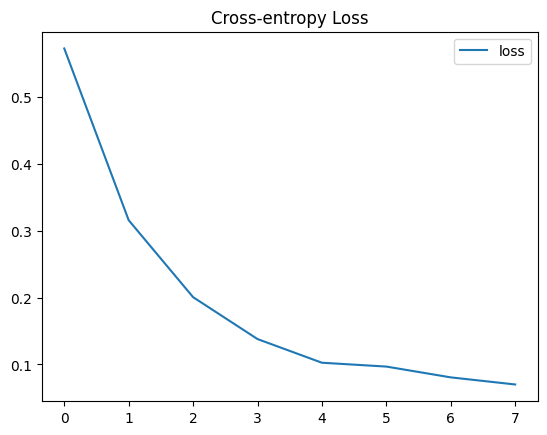

In [11]:
# Menampilkan nilai loss
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss']].plot(title="Cross-entropy Loss")
history_df

In [12]:
model_ABSA = load_model(model_ABSA, model_name)

In [13]:
# Classification report
x, y = test_model_ABSA(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(3)]))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       806
           1       0.85      0.90      0.87       808
           2       0.88      0.87      0.87       799

    accuracy                           0.90      2413
   macro avg       0.90      0.90      0.90      2413
weighted avg       0.90      0.90      0.90      2413

